# Machine Learning Models with the engineered features, kfold cross-validation and Gridsearch Hyperparameter Tuning

In [1]:
#Import the libraries

In [2]:
import pandas as pd

In [3]:
# Import the CSV files back as DataFrames

In [4]:
# Read the engineered training set features
X_train_eng = pd.read_csv('X_train_eng.csv')

# Read the engineered testing set features
X_test_eng = pd.read_csv('X_test_eng.csv')

# Read the training set labels (target variable)
y_train = pd.read_csv('y_train.csv')['location'].values

# Read the testing set labels (target variable)
y_test = pd.read_csv('y_test.csv')['location'].values

In [5]:
# Set a random seed for reproducibility
random_seed = 1

In [6]:
# Declare function for evaluating models beforehand and should be called whenever the model is to be evaluated

In [7]:
# Import required libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, matthews_corrcoef
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time

def calculate_metrics(y_true, y_preds, probas):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_preds)
    metrics['precision'] = precision_score(y_true, y_preds)
    metrics['recall'] = recall_score(y_true, y_preds)
    metrics['f1'] = f1_score(y_true, y_preds)
    metrics['matthews'] = matthews_corrcoef(y_true, y_preds)
    metrics['conf_matrix'] = confusion_matrix(y_true, y_preds)
    fpr, tpr, _ = roc_curve(y_true, probas)
    metrics['roc_auc'] = auc(fpr, tpr)
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr
    return metrics

def plot_metrics(train_metrics, test_metrics):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # ROC Curve
    axs[0].plot(train_metrics['fpr'], train_metrics['tpr'], color='darkorange', lw=2, label='Train ROC curve (area = %0.2f)' % train_metrics['roc_auc'])
    axs[0].plot(test_metrics['fpr'], test_metrics['tpr'], color='cornflowerblue', lw=2, label='Test ROC curve (area = %0.2f)' % test_metrics['roc_auc'])
    axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic')
    axs[0].legend(loc="lower right")

    # Confusion Matrix for Training Set
    sns.heatmap(train_metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues', ax=axs[1])
    axs[1].set_title('Confusion Matrix - Training Set')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')

    # Confusion Matrix for Testing Set
    sns.heatmap(test_metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues', ax=axs[2])
    axs[2].set_title('Confusion Matrix - Testing Set')
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    start_time = time.time()
    train_preds = model.predict(X_train)
    train_probas = model.predict_proba(X_train)[:, 1]
    train_metrics = calculate_metrics(y_train, train_preds, train_probas)

    test_preds = model.predict(X_test)
    test_probas = model.predict_proba(X_test)[:, 1]
    test_metrics = calculate_metrics(y_test, test_preds, test_probas)
    end_time = time.time()
    time_taken = (end_time - start_time) * 1000

    metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "Matthews", "ROC AUC"],
        "Training Set": [train_metrics[m] for m in ["accuracy", "precision", "recall", "f1", "matthews", "roc_auc"]],
        "Testing Set": [test_metrics[m] for m in ["accuracy", "precision", "recall", "f1", "matthews", "roc_auc"]]
    }).round(4)
    metrics_df.set_index("Metric", inplace=True)
    metrics_df.to_excel("metrics_output.xlsx")
    print(f"\nModel: {model_name}")
    print(metrics_df)
    print(f"Time Taken (ms): {time_taken}")

    plot_metrics(train_metrics, test_metrics)

# Logistic Regression

In [8]:
#Import the libraries

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Hyperparameter Tuning using GridSearchCV

In [11]:
# Defining the parameter grid for Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10000]
}

# Creating the GridSearchCV object for Logistic Regression
grid_search_lr = GridSearchCV(estimator=LogisticRegression(random_state=random_seed), param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=1)

# Fitting the grid search to the original training data
grid_search_lr.fit(X_train_eng, y_train)

# Getting the best parameters and score
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

best_params_lr, best_score_lr

Fitting 5 folds for each of 120 candidates, totalling 600 fits


({'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'sag'}, 0.9708984375)

In [12]:
# Creating the Logistic Regression model with the best hyperparameters
best_lr_model = LogisticRegression(**best_params_lr, random_state=random_seed)
best_lr_model.fit(X_train_eng, y_train)

LogisticRegression(C=0.1, max_iter=10000, random_state=1, solver='sag')

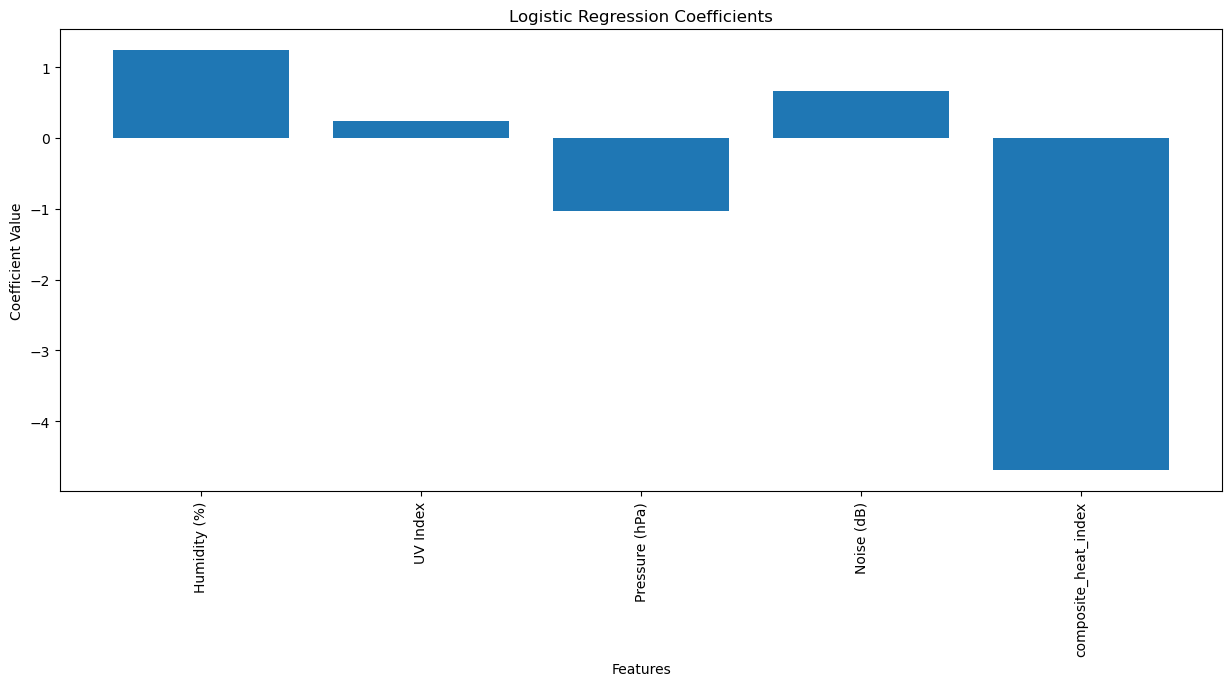

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_lr_model is your trained Logistic Regression model
coefficients = best_lr_model.coef_[0]

# Plotting the coefficients
plt.figure(figsize=(15, 6))
plt.bar(X_train_eng.columns, coefficients)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [14]:
# Let us call the evaluation metrics function


Model: Best Logistic Regression Model
           Training Set  Testing Set
Metric                              
Accuracy         0.9709       0.9688
Precision        0.9748       0.9717
Recall           0.9668       0.9656
F1-Score         0.9708       0.9687
Matthews         0.9418       0.9375
ROC AUC          0.9849       0.9816
Time Taken (ms): 53.9698600769043


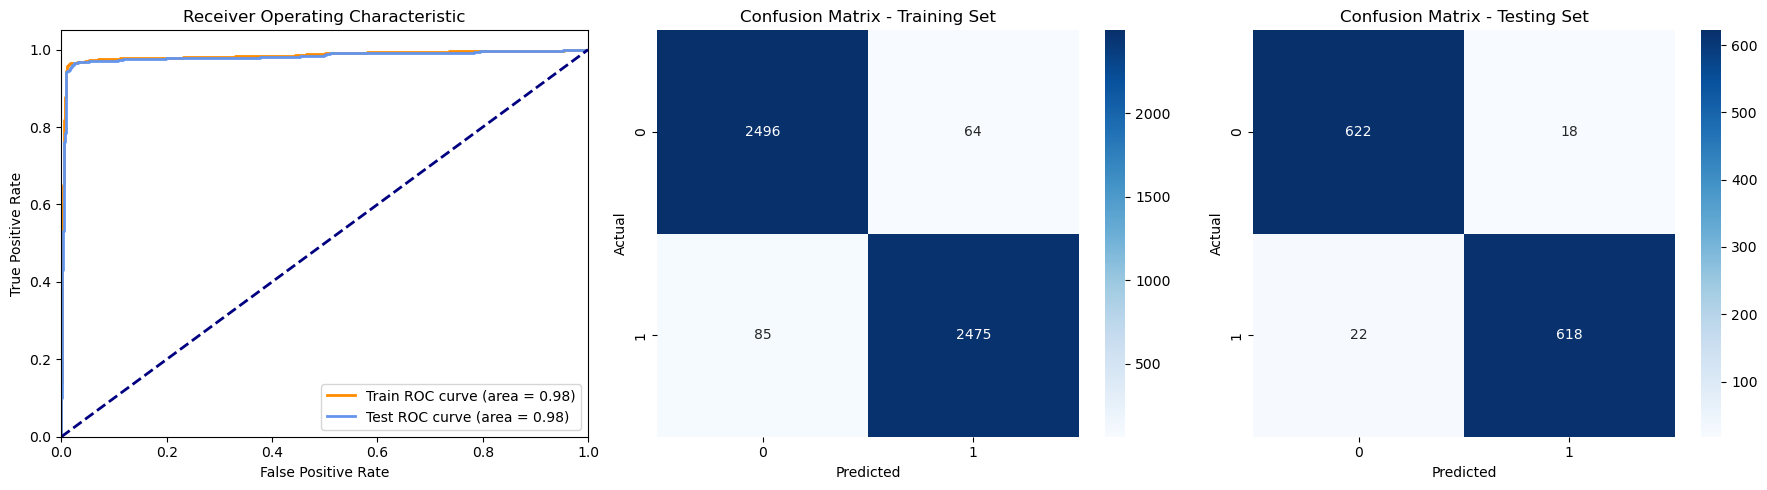

In [15]:
evaluate_model(best_lr_model, X_train_eng, y_train, X_test_eng, y_test, 'Best Logistic Regression Model')

# Decision Trees

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid for Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Creating the GridSearchCV object for Decision Tree
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=random_seed), param_grid=param_grid_dt, cv=5, n_jobs=-1, verbose=1)

# Fitting the grid search to the original training data
grid_search_dt.fit(X_train_eng, y_train)

# Getting the best parameters and score
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

# Printing the best parameters and score
print(best_params_dt, best_score_dt)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'} 0.9984375


In [18]:
# Creating the Decision Tree model with the best hyperparameters
best_dt_model = DecisionTreeClassifier(**best_params_dt, random_state=random_seed)
best_dt_model.fit(X_train_eng, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [19]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


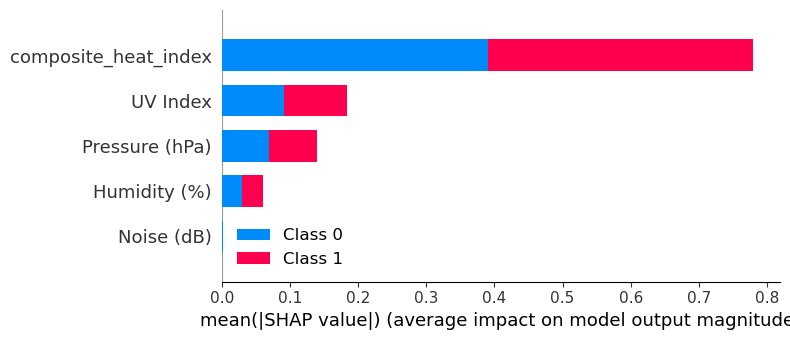

In [20]:
import shap

# Compute SHAP values
explainer = shap.TreeExplainer(best_dt_model)
shap_values = explainer.shap_values(X_train_eng)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train_eng)

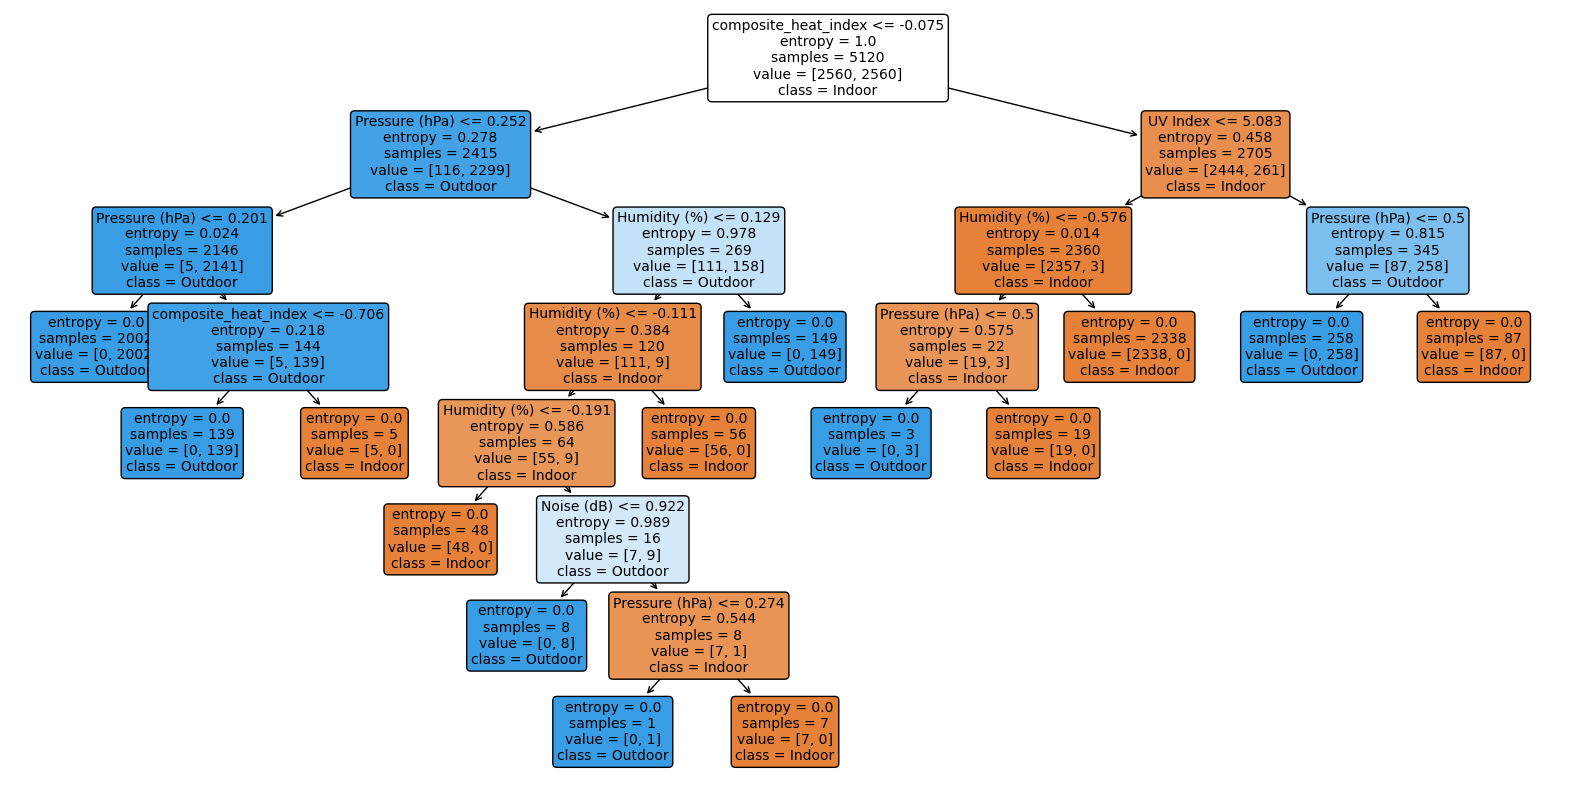

In [21]:
from sklearn import tree
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 10))

# Plot the decision tree
tree.plot_tree(best_dt_model,
               feature_names=X_train_eng.columns,  # feature names
               class_names=['Indoor', 'Outdoor'],
               filled=True,
               rounded=True,
               fontsize=10)

plt.show()

In [22]:
# Let evaluate the decision tree model


Model: Best Decision Tree Model
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9984
Precision           1.0       0.9969
Recall              1.0       1.0000
F1-Score            1.0       0.9984
Matthews            1.0       0.9969
ROC AUC             1.0       0.9984
Time Taken (ms): 28.995513916015625


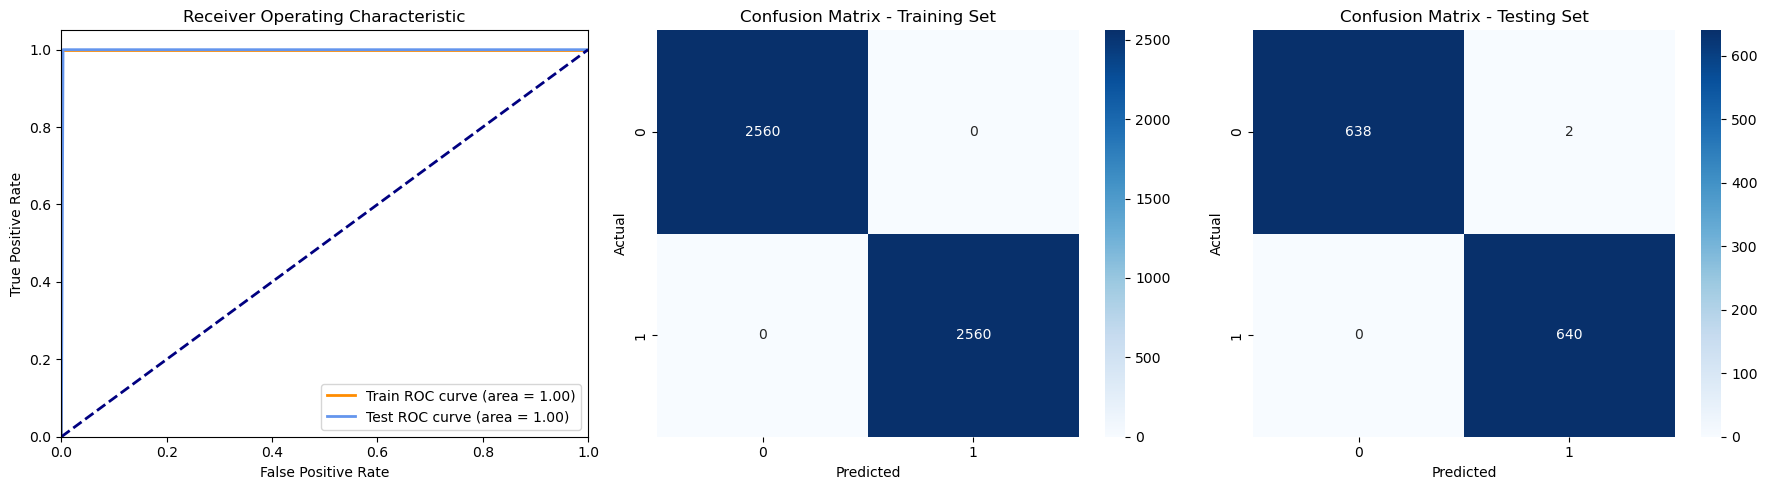

In [23]:
# Evaluate the best Decision Tree model
evaluate_model(best_dt_model, X_train_eng, y_train, X_test_eng, y_test, 'Best Decision Tree Model')

# Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Defining the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True]
}

# Creating the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=random_seed), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=1)

# Fitting the grid search to the original training data
grid_search_rf.fit(X_train_eng, y_train)

# Getting the best parameters and score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Printing the best parameters and score
print(best_params_rf, best_score_rf)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50} 0.9984375


In [26]:
# Creating the Random Forest model with the best hyperparameters

In [27]:
best_rf_model = RandomForestClassifier(**best_params_rf, random_state=random_seed)
best_rf_model.fit(X_train_eng, y_train)

RandomForestClassifier(n_estimators=50, random_state=1)

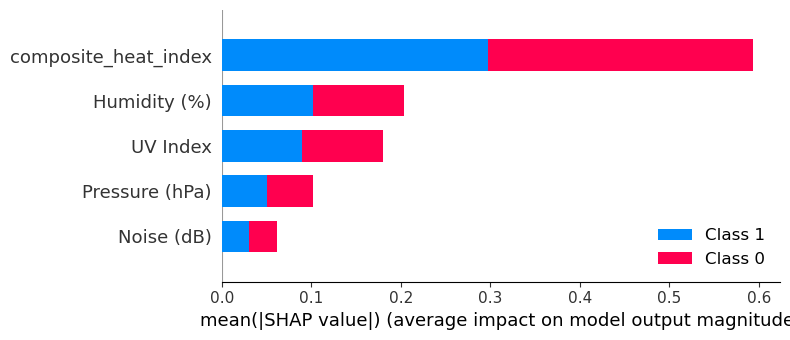

In [28]:
import shap

# Compute SHAP values
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_train_eng)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train_eng)

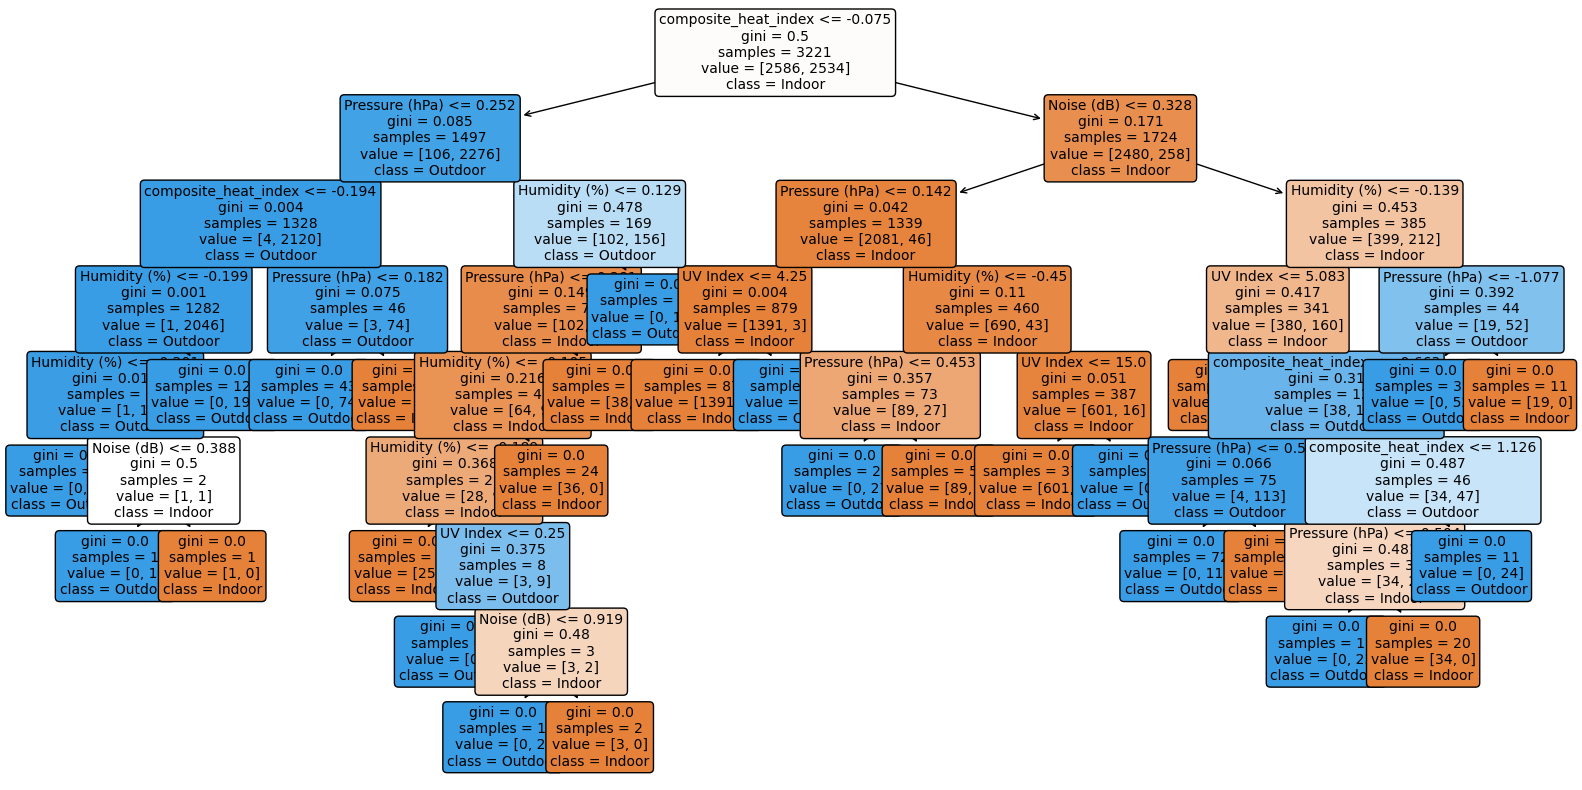

In [29]:
import matplotlib.pyplot as plt

# Assuming best_rf_model is your trained Random Forest model
first_tree = best_rf_model.estimators_[0]

# Set the figure size
plt.figure(figsize=(20, 10))

# Plot the first decision tree
tree.plot_tree(first_tree,
               feature_names=X_train_eng.columns,  # feature names
               class_names=['Indoor', 'Outdoor'],
               filled=True,
               rounded=True,
               fontsize=10)

plt.show()

In [30]:
# Evaluate the best Random Forest model


Model: Best Random Forest Model
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9984
Precision           1.0       0.9969
Recall              1.0       1.0000
F1-Score            1.0       0.9984
Matthews            1.0       0.9969
ROC AUC             1.0       1.0000
Time Taken (ms): 100.95381736755371


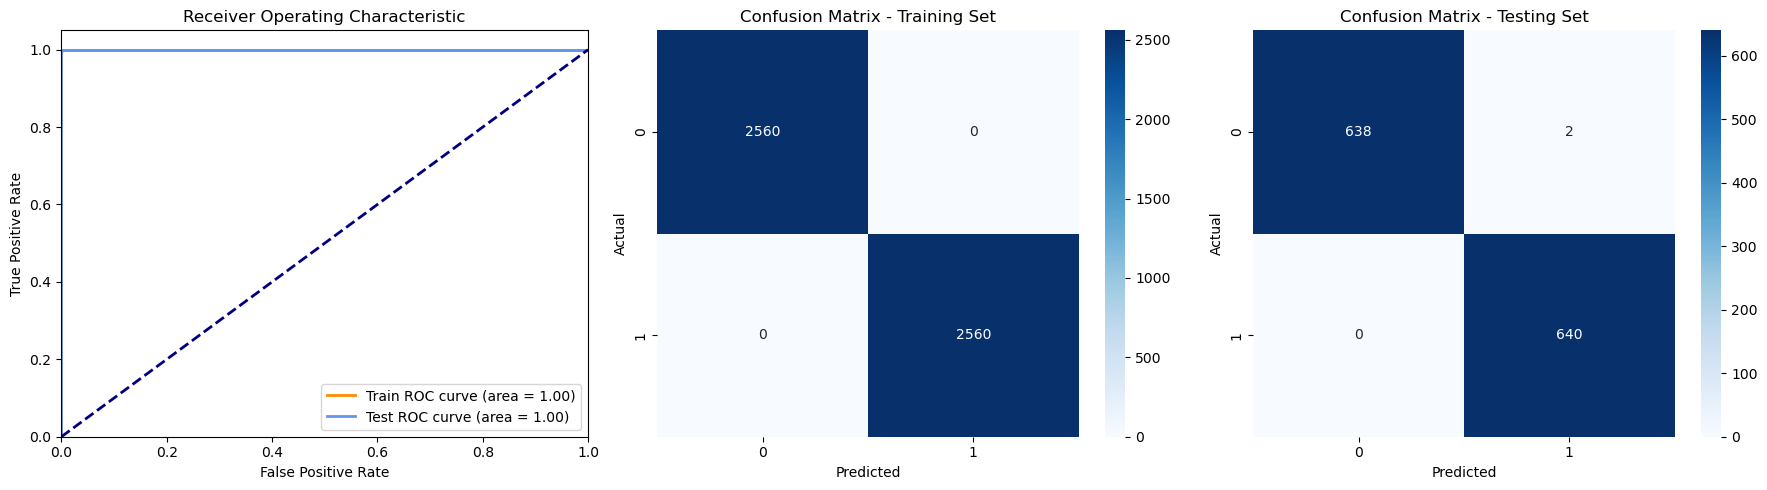

In [31]:
evaluate_model(best_rf_model, X_train_eng, y_train, X_test_eng, y_test, 'Best Random Forest Model')

# Gradient Boosting Machines

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbm = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 1],
    'max_depth': [3, 5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'subsample': [0.9, 1.0],
    'max_features': [None, 'sqrt']
}

# Creating the GridSearchCV object for Gradient Boosting
grid_search_gbm = GridSearchCV(estimator=GradientBoostingClassifier(random_state=random_seed), param_grid=param_grid_gbm, cv=5, n_jobs=-1, verbose=1)

# Fitting the grid search to the original training data
grid_search_gbm.fit(X_train_eng, y_train)

# Getting the best parameters and score
best_params_gbm = grid_search_gbm.best_params_
best_score_gbm = grid_search_gbm.best_score_

# Printing the best parameters and score
print(best_params_gbm, best_score_gbm)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.9} 0.9984375


In [34]:
# Creating the Gradient Boosting model with the best hyperparameters

In [35]:
best_gbm_model = GradientBoostingClassifier(**best_params_gbm, random_state=random_seed)
best_gbm_model.fit(X_train_eng, y_train)

GradientBoostingClassifier(max_depth=5, random_state=1, subsample=0.9)

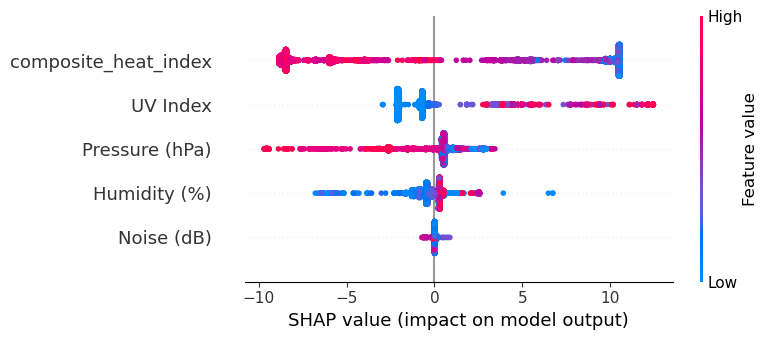

In [36]:
import shap

# Compute SHAP values
explainer = shap.TreeExplainer(best_gbm_model)
shap_values = explainer.shap_values(X_train_eng)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train_eng)

In [37]:
# Evaluate the best Gradient Boosting model


Model: Best Gradient Boosting Model
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9977
Precision           1.0       0.9953
Recall              1.0       1.0000
F1-Score            1.0       0.9977
Matthews            1.0       0.9953
ROC AUC             1.0       1.0000
Time Taken (ms): 51.95260047912598


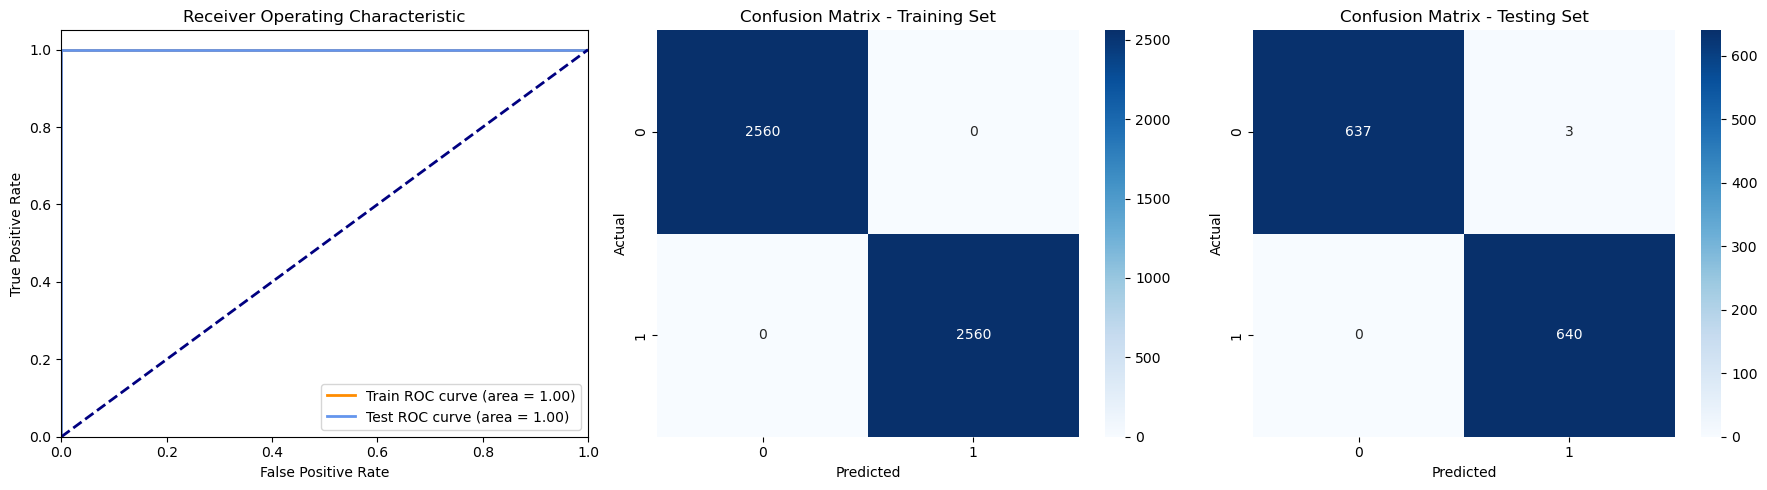

In [38]:
evaluate_model(best_gbm_model, X_train_eng, y_train, X_test_eng, y_test, 'Best Gradient Boosting Model')

# Support Vector Machines

In [39]:
from sklearn.svm import SVC

In [40]:
# Defining the parameter grid for SVM
param_grid_svm = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [3],  # Only used if kernel='poly'
    'gamma': ['scale']
}
# Creating the GridSearchCV object for SVM
grid_search_svm = GridSearchCV(estimator=SVC(probability=True, random_state=random_seed), param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=1)

# Fitting the grid search to the original training data
grid_search_svm.fit(X_train_eng, y_train)

# Getting the best parameters and score
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

# Printing the best parameters and score
print(best_params_svm, best_score_svm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'} 0.9912109375


In [41]:
# Creating the SVM model with the best hyperparameters

In [42]:
best_svm_model = SVC(**best_params_svm, probability=True, random_state=random_seed)
best_svm_model.fit(X_train_eng, y_train)

SVC(C=10, probability=True, random_state=1)

In [45]:
# Evaluate the best SVM model


Model: Best Support Vector Machine Model
           Training Set  Testing Set
Metric                              
Accuracy         0.9932       0.9914
Precision        0.9961       0.9937
Recall           0.9902       0.9891
F1-Score         0.9931       0.9914
Matthews         0.9863       0.9828
ROC AUC          0.9991       0.9991
Time Taken (ms): 571.6872215270996


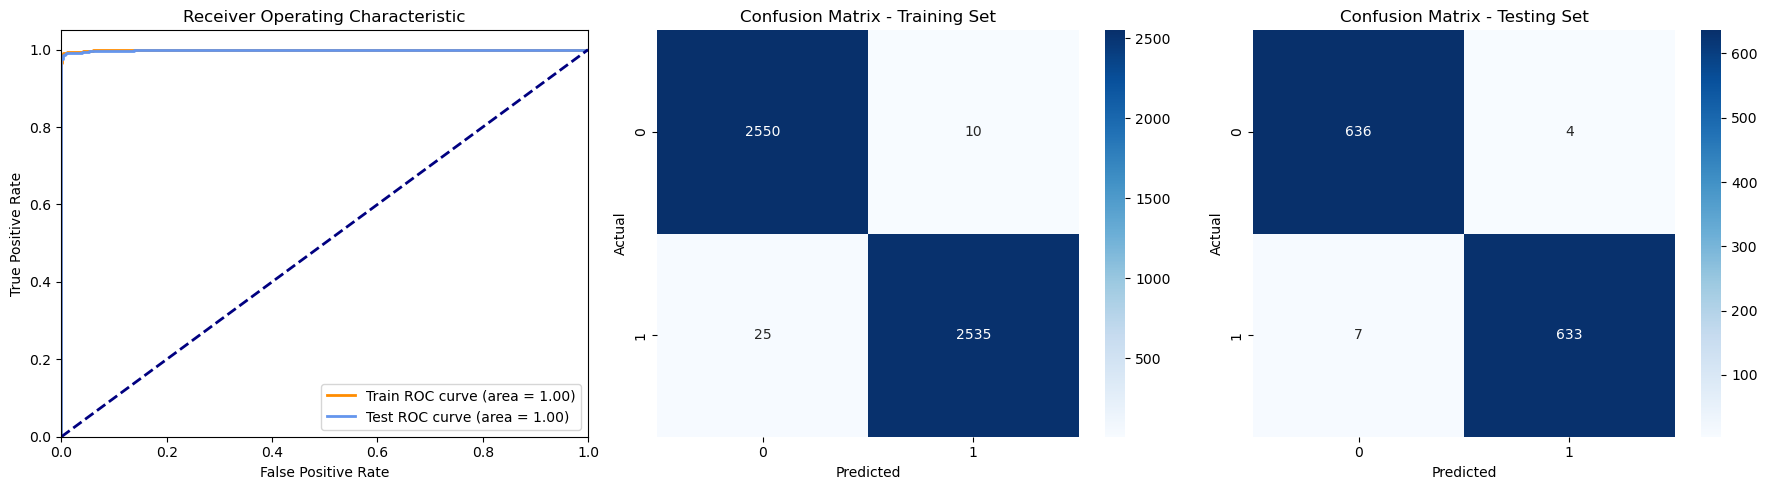

In [46]:
evaluate_model(best_svm_model, X_train_eng, y_train, X_test_eng, y_test, 'Best Support Vector Machine Model')

# K-Nearest Neighbors

In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
# Defining the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': list(range(1, 11)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'kd_tree'],
    'p': [1, 2]
}

# Creating the GridSearchCV object for KNN
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, n_jobs=-1, verbose=1)

# Fitting the grid search to the original training data
grid_search_knn.fit(X_train_eng, y_train)

# Getting the best parameters and score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

# Printing the best parameters and score
print(best_params_knn, best_score_knn)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'} 0.99296875


In [49]:
# Creating the KNN model with the best hyperparameters

In [50]:
best_knn_model = KNeighborsClassifier(**best_params_knn)
best_knn_model.fit(X_train_eng, y_train)

KNeighborsClassifier(p=1, weights='distance')

In [53]:
# Evaluate the best KNN model


Model: Best K-Nearest Neighbors Model
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9961
Precision           1.0       0.9969
Recall              1.0       0.9953
F1-Score            1.0       0.9961
Matthews            1.0       0.9922
ROC AUC             1.0       0.9992
Time Taken (ms): 96.94218635559082


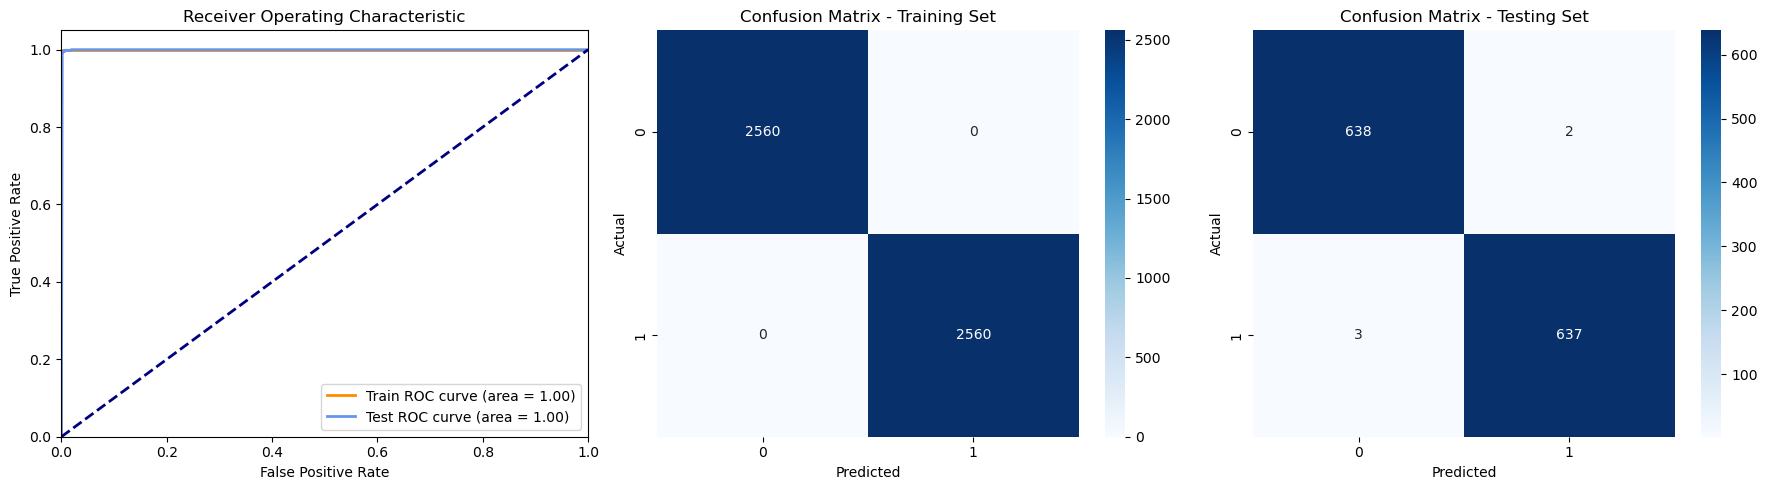

In [54]:
evaluate_model(best_knn_model, X_train_eng, y_train, X_test_eng, y_test, 'Best K-Nearest Neighbors Model')

# Ada Boost

In [55]:
from sklearn.ensemble import AdaBoostClassifier

In [56]:
# Defining the parameter grid for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.5],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Creating the GridSearchCV object for AdaBoost
grid_search_ada = GridSearchCV(estimator=AdaBoostClassifier(random_state=random_seed), param_grid=param_grid_ada, cv=5, n_jobs=-1, verbose=1)

# Fitting the grid search to the original training data
grid_search_ada.fit(X_train_eng, y_train)

# Getting the best parameters and score
best_params_ada = grid_search_ada.best_params_
best_score_ada = grid_search_ada.best_score_

# Printing the best parameters and score
print(best_params_ada, best_score_ada)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 100} 0.9982421875


In [57]:
# Creating the AdaBoost model with the best hyperparameters

In [58]:
best_ada_model = AdaBoostClassifier(**best_params_ada, random_state=random_seed)
best_ada_model.fit(X_train_eng, y_train)

AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=1)

In [59]:
# Evaluate the best AdaBoost model


Model: Best AdaBoost Classifier Model
           Training Set  Testing Set
Metric                              
Accuracy         0.9998       0.9984
Precision        1.0000       0.9969
Recall           0.9996       1.0000
F1-Score         0.9998       0.9984
Matthews         0.9996       0.9969
ROC AUC          1.0000       0.9994
Time Taken (ms): 232.8808307647705


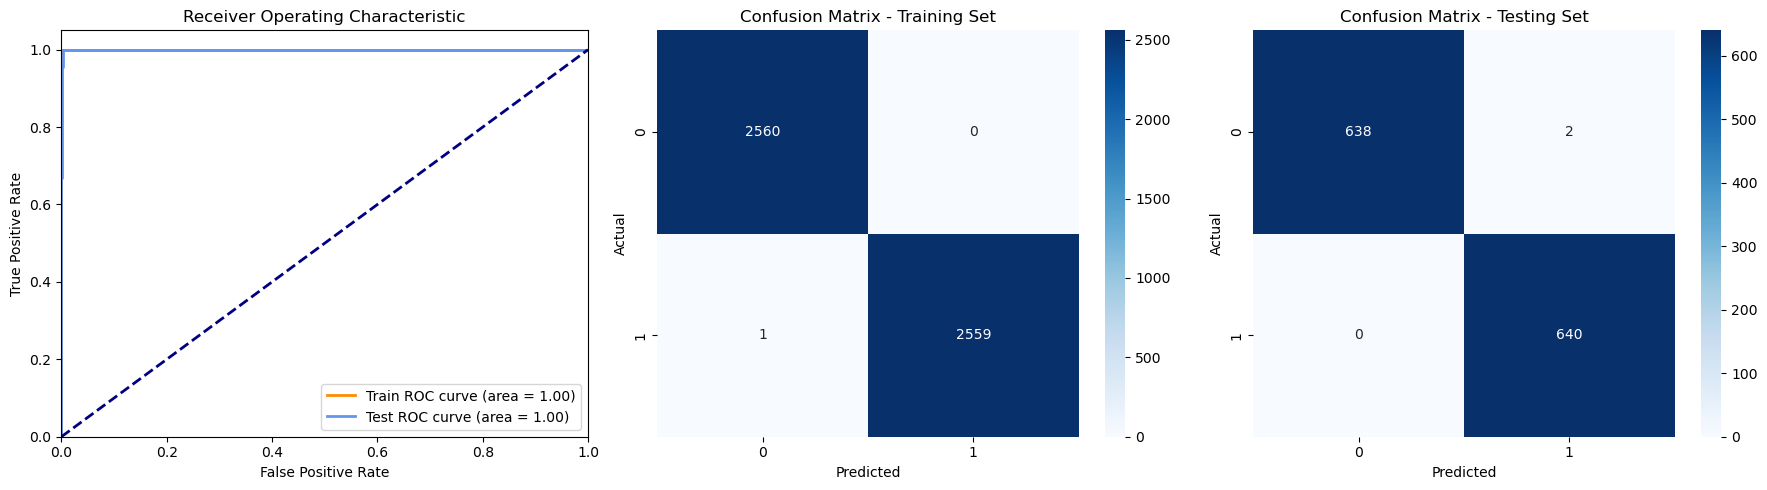

In [60]:
evaluate_model(best_ada_model, X_train_eng, y_train, X_test_eng, y_test, 'Best AdaBoost Classifier Model')

# Stochastic Gradient Descent

In [61]:
from sklearn.linear_model import SGDClassifier

In [62]:

param_grid_sgd = {
    'loss': ['log'],
    'penalty': ['l2', 'elasticnet'],
    'alpha': [0.0001, 0.01],
    'learning_rate': ['optimal', 'adaptive']
}

# Creating the GridSearchCV object for SGD
grid_search_sgd = GridSearchCV(estimator=SGDClassifier(random_state=random_seed, max_iter=1000), param_grid=param_grid_sgd, cv=5, n_jobs=-1, verbose=1)

# Fitting the grid search to the original training data
grid_search_sgd.fit(X_train_eng, y_train)

# Getting the best parameters and score
best_params_sgd = grid_search_sgd.best_params_
best_score_sgd = grid_search_sgd.best_score_

# Printing the best parameters and score
print(best_params_sgd, best_score_sgd)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'penalty': 'elasticnet'} 0.9703125


In [63]:
# Creating the SGD model with the best hyperparameters

In [64]:
best_sgd_model = SGDClassifier(**best_params_sgd, random_state=random_seed, max_iter=1000)
best_sgd_model.fit(X_train_eng, y_train)

SGDClassifier(alpha=0.01, loss='log', penalty='elasticnet', random_state=1)

In [65]:
# Evaluate the best SGD model


Model: Best Stochastic Gradient Descent Model
           Training Set  Testing Set
Metric                              
Accuracy         0.9689       0.9680
Precision        0.9754       0.9731
Recall           0.9621       0.9625
F1-Score         0.9687       0.9678
Matthews         0.9380       0.9360
ROC AUC          0.9839       0.9808
Time Taken (ms): 30.981779098510742


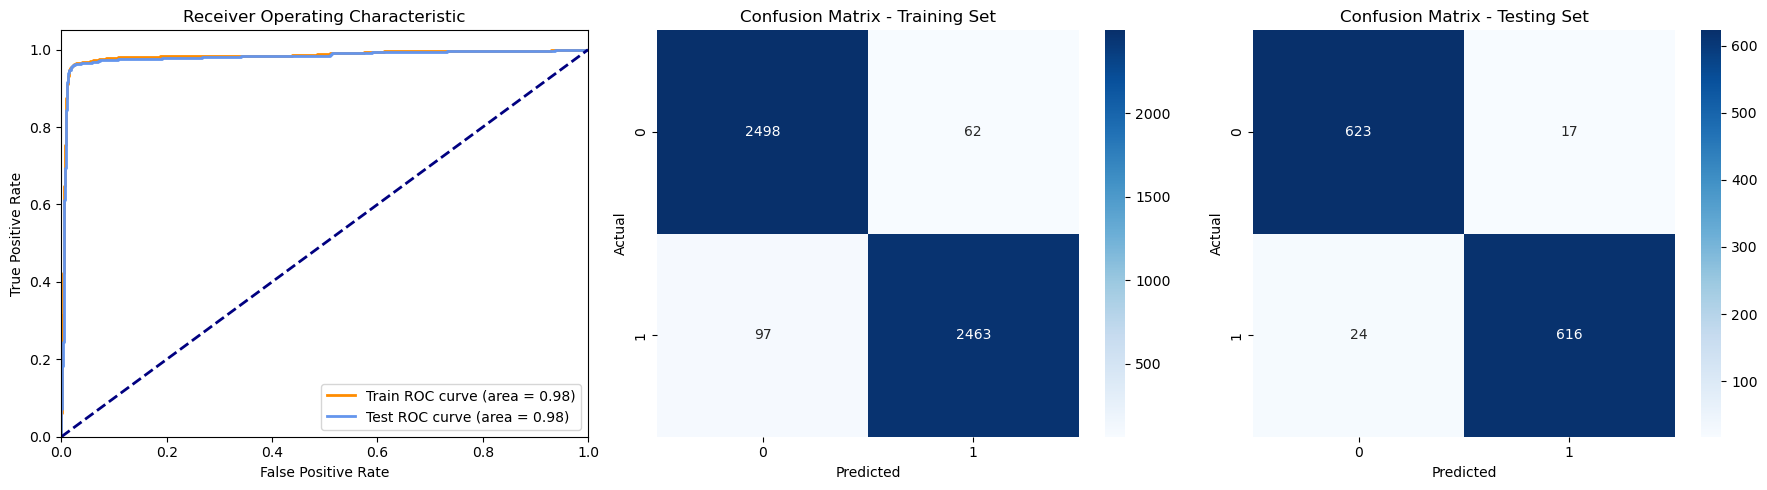

In [66]:
evaluate_model(best_sgd_model, X_train_eng, y_train, X_test_eng, y_test, 'Best Stochastic Gradient Descent Model')

# The Multi-Layer Perceptron (MLP)

In [67]:
from sklearn.neural_network import MLPClassifier

In [68]:
# Defining the parameter grid for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 400]
}

# Creating the GridSearchCV object for MLP
grid_search_mlp = GridSearchCV(estimator=MLPClassifier(random_state=random_seed), param_grid=param_grid_mlp, cv=5, n_jobs=-1, verbose=1)

# Fitting the grid search to the original training data
grid_search_mlp.fit(X_train_eng, y_train)

# Getting the best parameters and score
best_params_mlp = grid_search_mlp.best_params_
best_score_mlp = grid_search_mlp.best_score_

# Printing the best parameters and score
print(best_params_mlp, best_score_mlp)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'} 0.9978515625


In [69]:
# Creating the MLP model with the best hyperparameters

In [70]:
best_mlp_model = MLPClassifier(**best_params_mlp, random_state=random_seed)
best_mlp_model.fit(X_train_eng, y_train)

MLPClassifier(random_state=1)

In [71]:
# Evaluate the best MLP model


Model: Best MLP Classifier Model
           Training Set  Testing Set
Metric                              
Accuracy         0.9980       0.9992
Precision        1.0000       0.9984
Recall           0.9961       1.0000
F1-Score         0.9980       0.9992
Matthews         0.9961       0.9984
ROC AUC          0.9999       1.0000
Time Taken (ms): 53.969383239746094


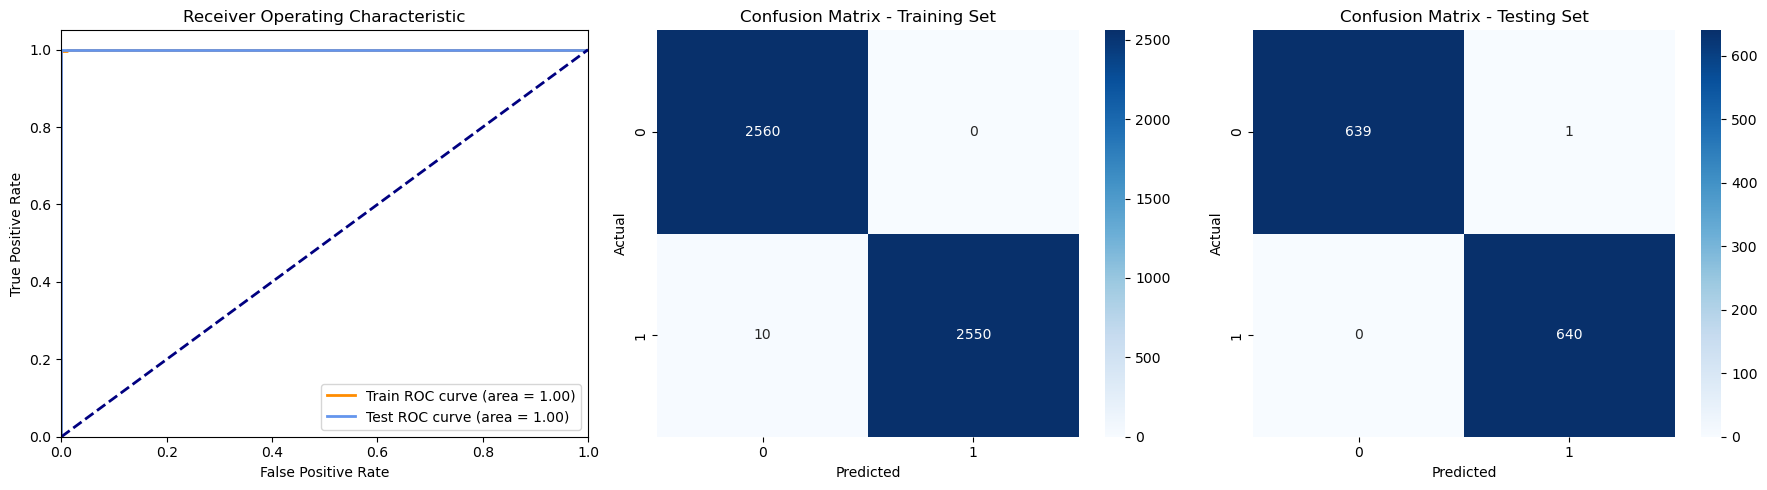

In [72]:
evaluate_model(best_mlp_model, X_train_eng, y_train, X_test_eng, y_test, 'Best MLP Classifier Model')

# Advanced Engineering using polynomial features to degree

In [73]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

Evaluating Random Forest with Polynomial Features:
Polynomial Degree: 1

Model: Random Forest with Polynomial Features (Degree 1)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9984
Precision           1.0       0.9969
Recall              1.0       1.0000
F1-Score            1.0       0.9984
Matthews            1.0       0.9969
ROC AUC             1.0       1.0000
Time Taken (ms): 101.95541381835938


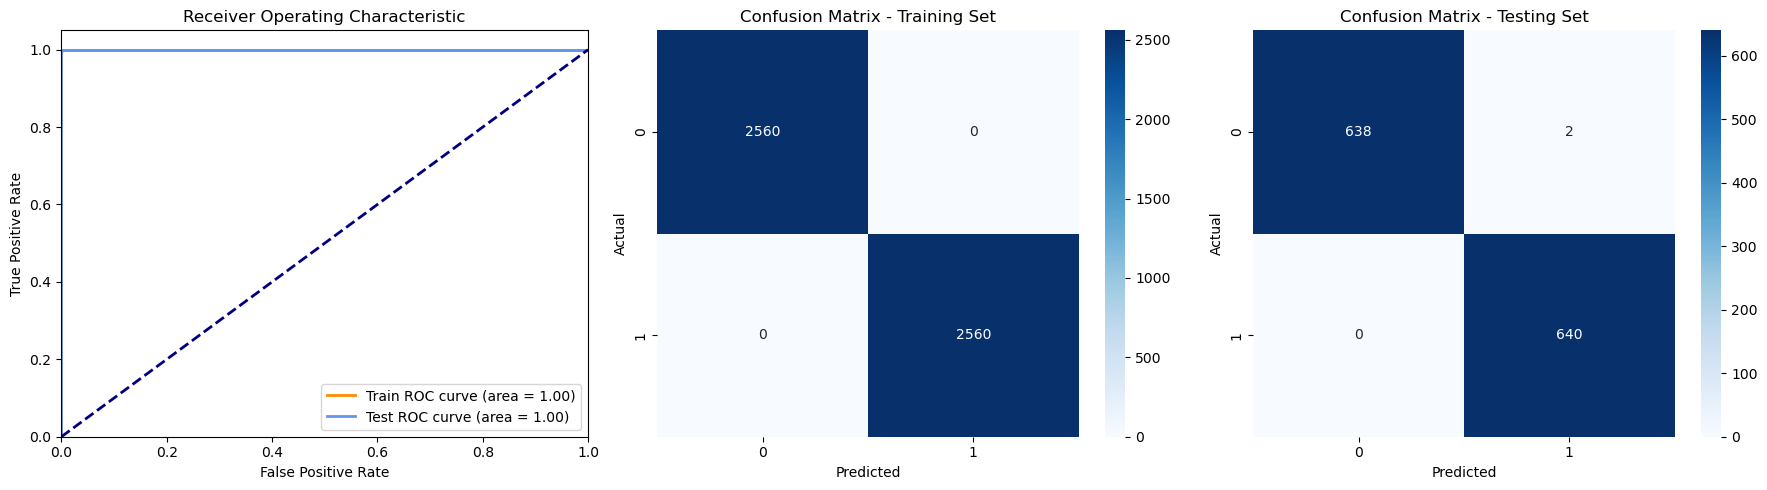



Polynomial Degree: 2

Model: Random Forest with Polynomial Features (Degree 2)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9984
Precision           1.0       0.9969
Recall              1.0       1.0000
F1-Score            1.0       0.9984
Matthews            1.0       0.9969
ROC AUC             1.0       1.0000
Time Taken (ms): 102.92720794677734


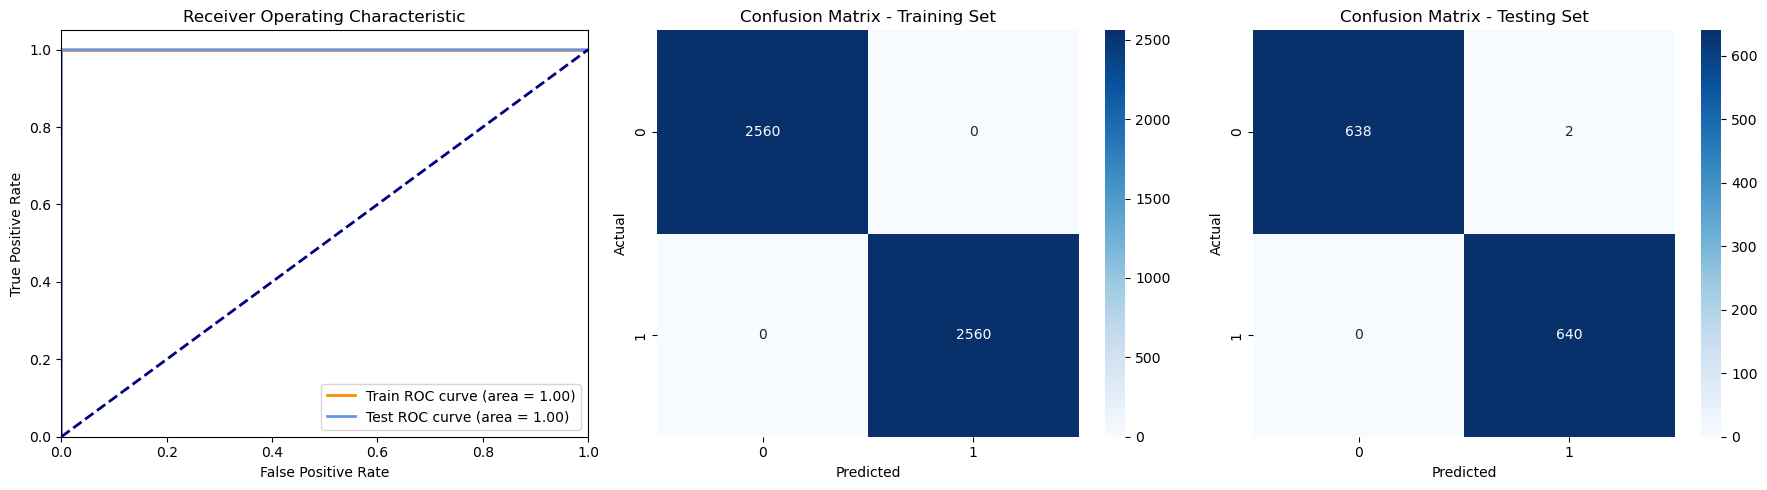



Polynomial Degree: 3

Model: Random Forest with Polynomial Features (Degree 3)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9992
Precision           1.0       0.9984
Recall              1.0       1.0000
F1-Score            1.0       0.9992
Matthews            1.0       0.9984
ROC AUC             1.0       1.0000
Time Taken (ms): 95.94297409057617


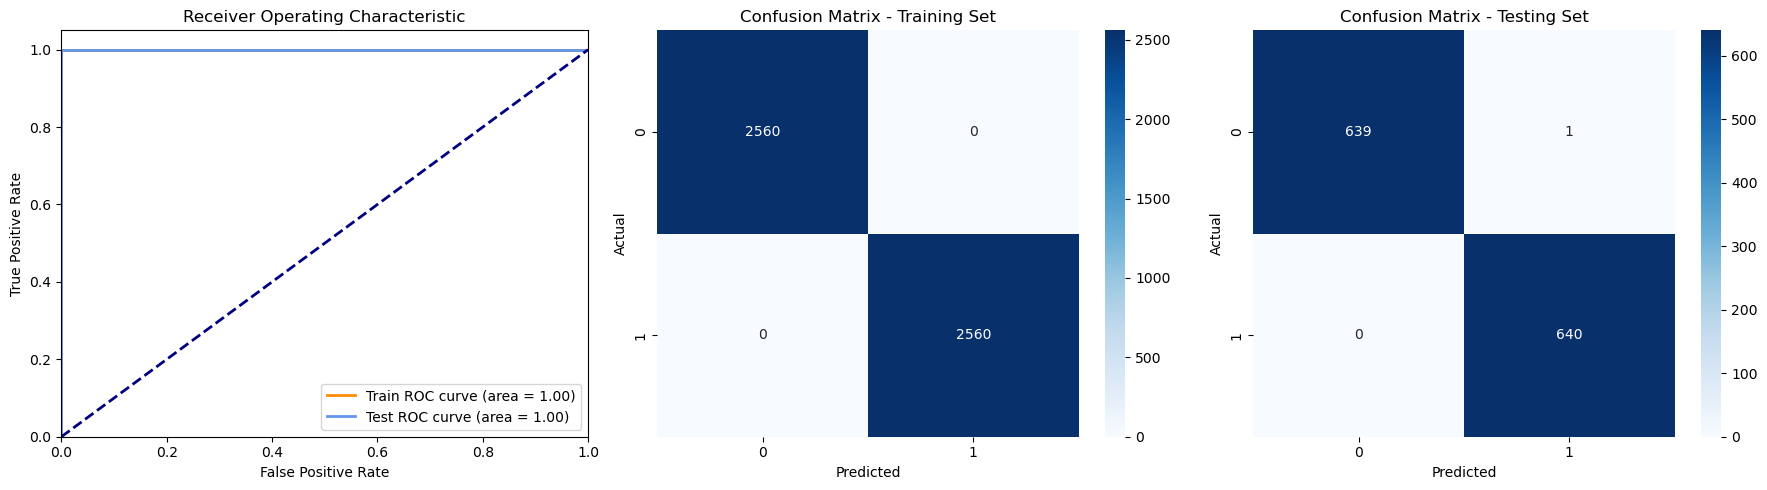



Polynomial Degree: 4

Model: Random Forest with Polynomial Features (Degree 4)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9984
Precision           1.0       0.9969
Recall              1.0       1.0000
F1-Score            1.0       0.9984
Matthews            1.0       0.9969
ROC AUC             1.0       1.0000
Time Taken (ms): 111.91749572753906


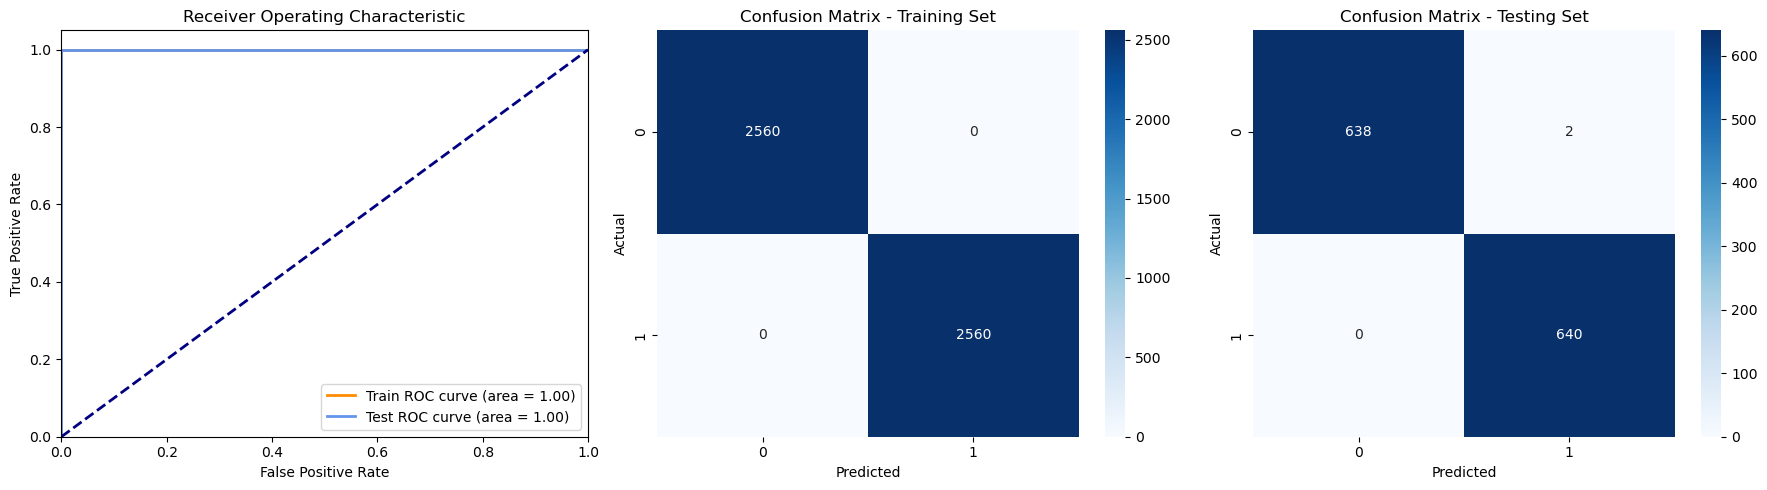



Evaluating Decision Tree with Polynomial Features:
Polynomial Degree: 1

Model: Decision Tree with Polynomial Features (Degree 1)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9984
Precision           1.0       0.9969
Recall              1.0       1.0000
F1-Score            1.0       0.9984
Matthews            1.0       0.9969
ROC AUC             1.0       0.9984
Time Taken (ms): 24.999380111694336


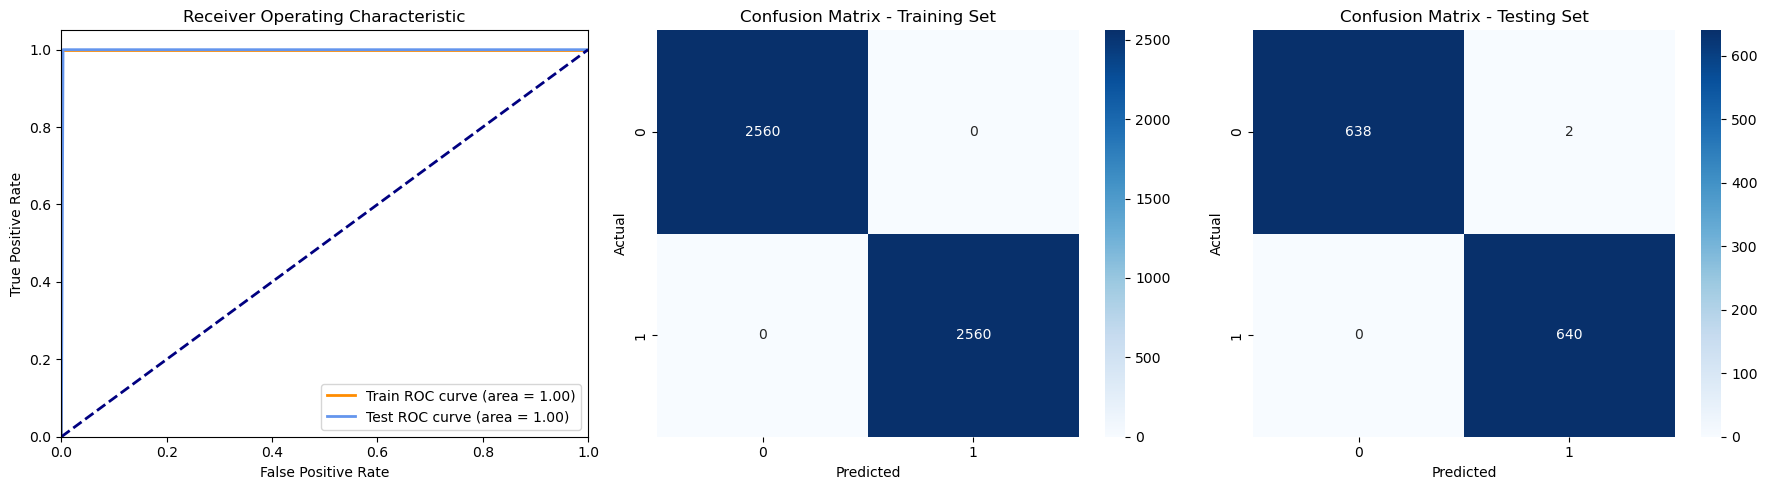



Polynomial Degree: 2

Model: Decision Tree with Polynomial Features (Degree 2)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9977
Precision           1.0       0.9953
Recall              1.0       1.0000
F1-Score            1.0       0.9977
Matthews            1.0       0.9953
ROC AUC             1.0       0.9977
Time Taken (ms): 25.980710983276367


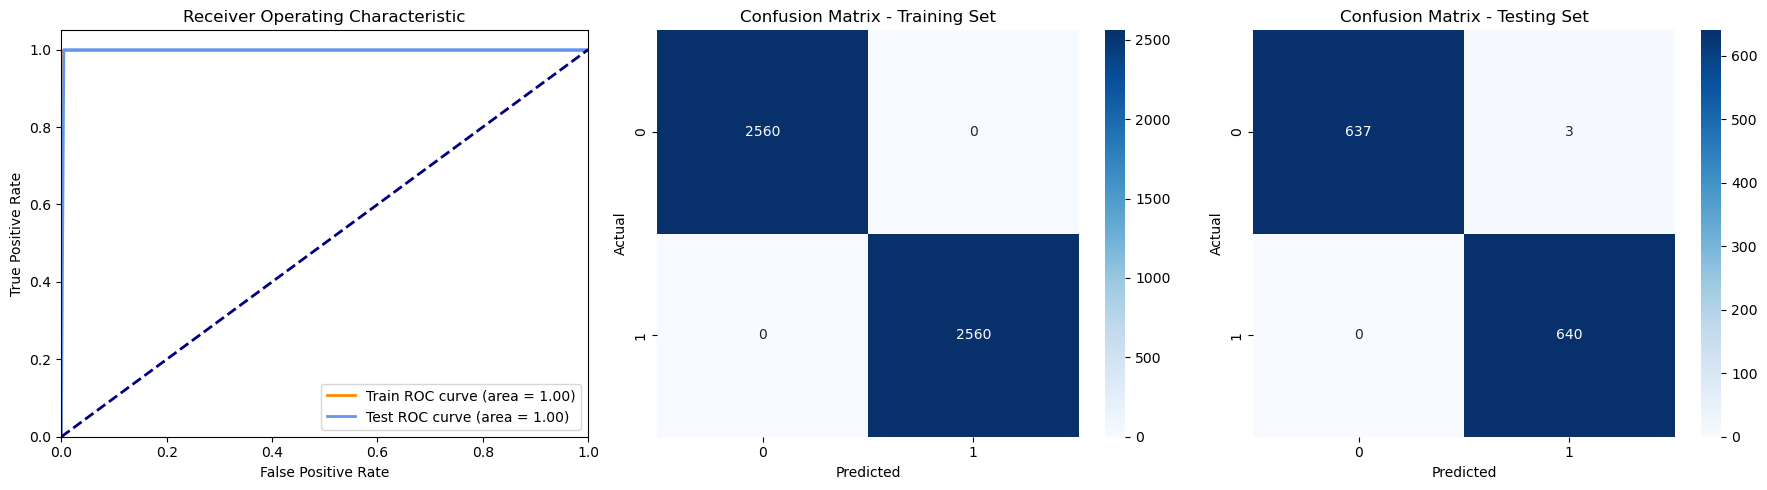



Polynomial Degree: 3

Model: Decision Tree with Polynomial Features (Degree 3)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9969
Precision           1.0       0.9938
Recall              1.0       1.0000
F1-Score            1.0       0.9969
Matthews            1.0       0.9938
ROC AUC             1.0       0.9969
Time Taken (ms): 31.97765350341797


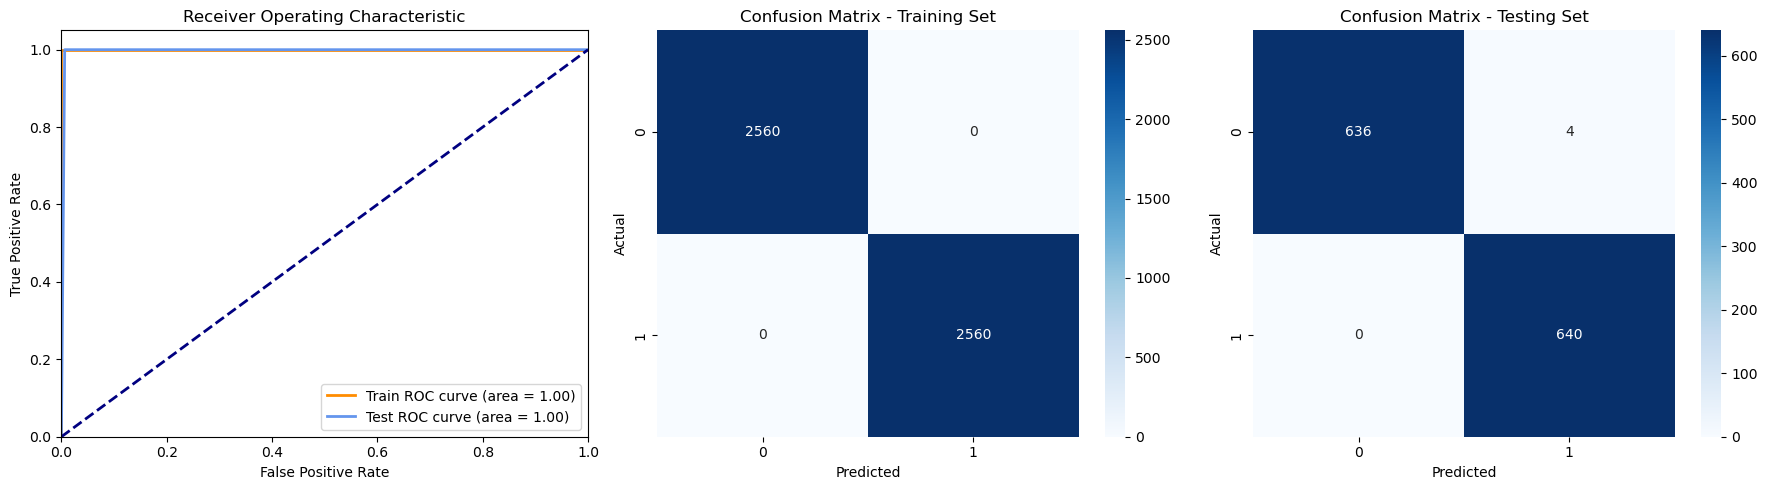



Polynomial Degree: 4

Model: Decision Tree with Polynomial Features (Degree 4)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9969
Precision           1.0       0.9938
Recall              1.0       1.0000
F1-Score            1.0       0.9969
Matthews            1.0       0.9938
ROC AUC             1.0       0.9969
Time Taken (ms): 42.975425720214844


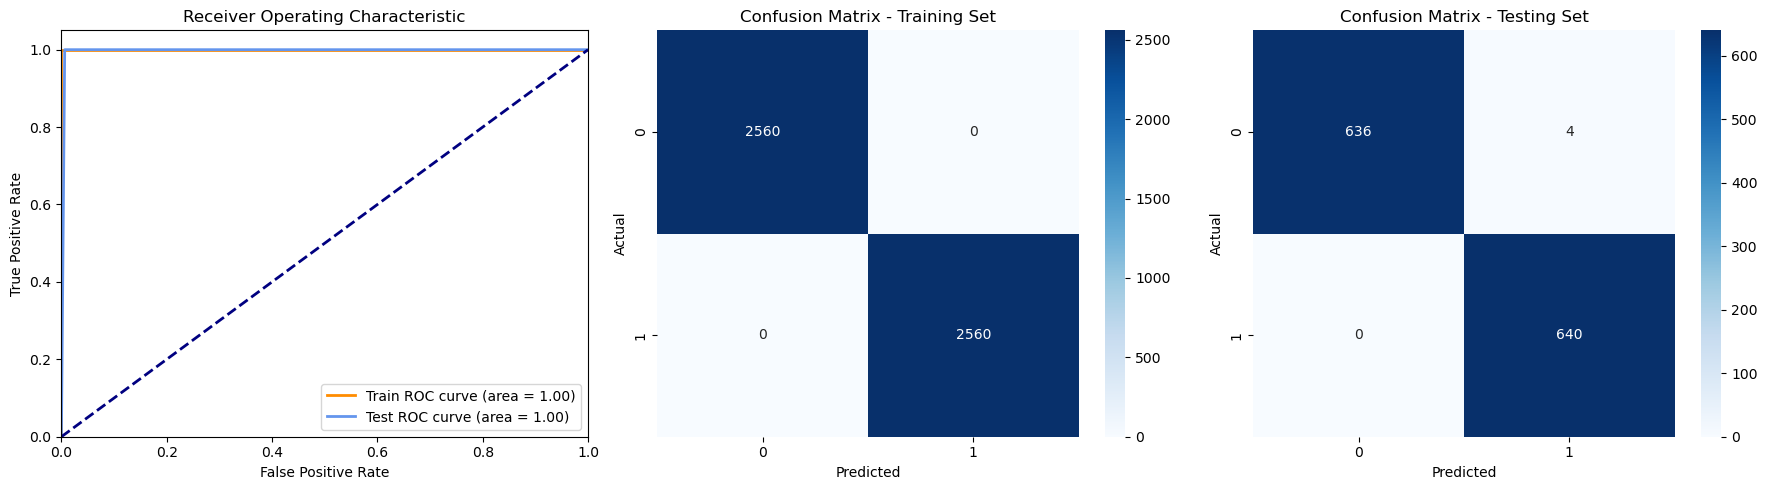



Evaluating AdaBoost with Polynomial Features:
Polynomial Degree: 1

Model: AdaBoost with Polynomial Features (Degree 1)
           Training Set  Testing Set
Metric                              
Accuracy         0.9998       0.9984
Precision        1.0000       0.9969
Recall           0.9996       1.0000
F1-Score         0.9998       0.9984
Matthews         0.9996       0.9969
ROC AUC          1.0000       0.9994
Time Taken (ms): 226.85599327087402


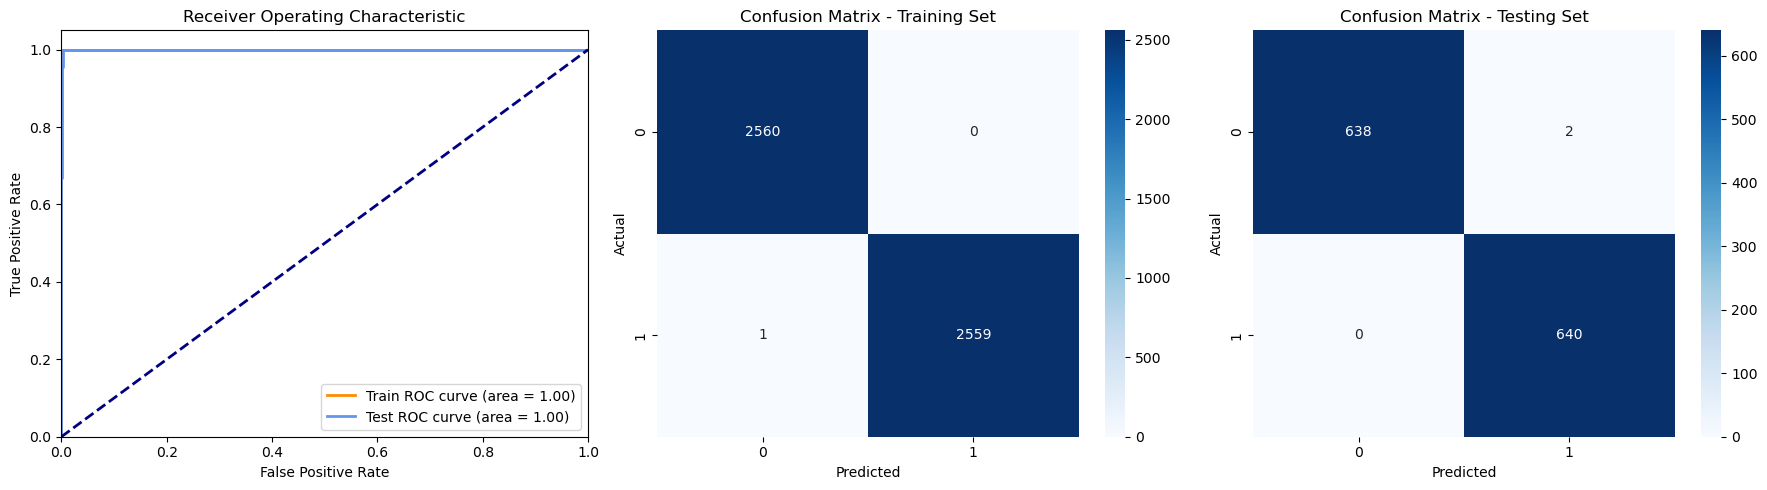



Polynomial Degree: 2

Model: AdaBoost with Polynomial Features (Degree 2)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9984
Precision           1.0       0.9969
Recall              1.0       1.0000
F1-Score            1.0       0.9984
Matthews            1.0       0.9969
ROC AUC             1.0       1.0000
Time Taken (ms): 246.842622756958


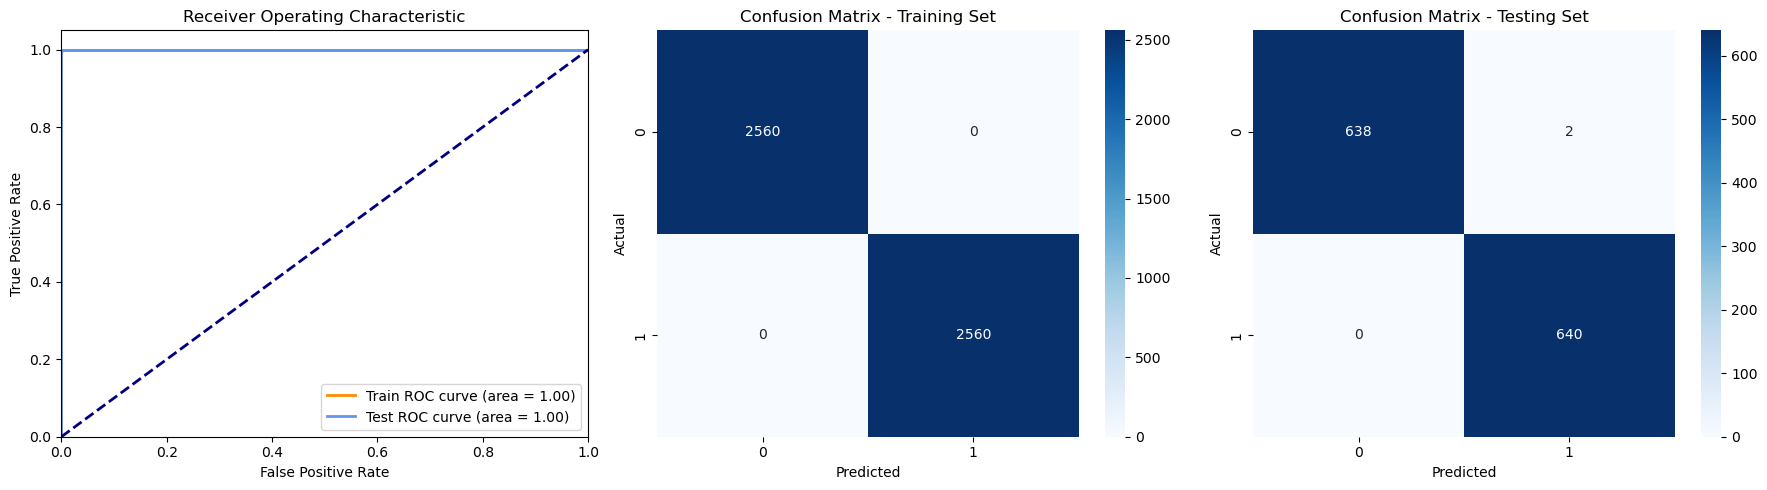



Polynomial Degree: 3

Model: AdaBoost with Polynomial Features (Degree 3)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9984
Precision           1.0       0.9969
Recall              1.0       1.0000
F1-Score            1.0       0.9984
Matthews            1.0       0.9969
ROC AUC             1.0       1.0000
Time Taken (ms): 525.7010459899902


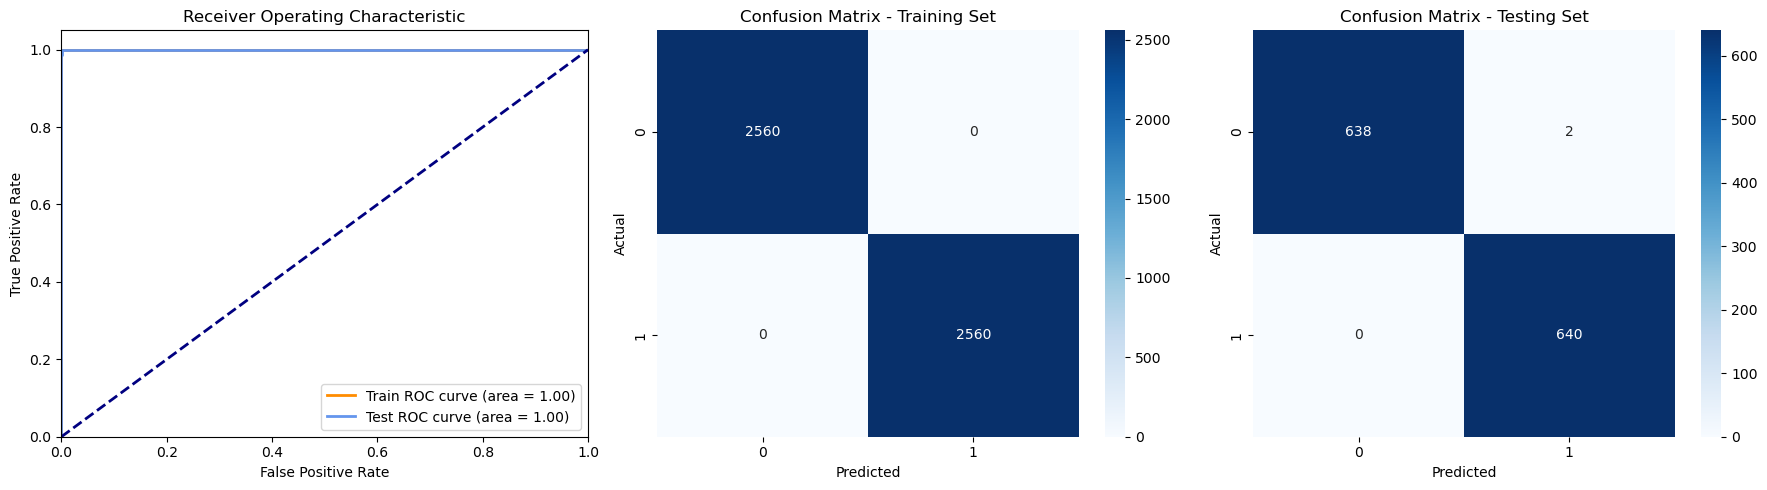



Polynomial Degree: 4

Model: AdaBoost with Polynomial Features (Degree 4)
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9984
Precision           1.0       0.9969
Recall              1.0       1.0000
F1-Score            1.0       0.9984
Matthews            1.0       0.9969
ROC AUC             1.0       1.0000
Time Taken (ms): 645.632266998291


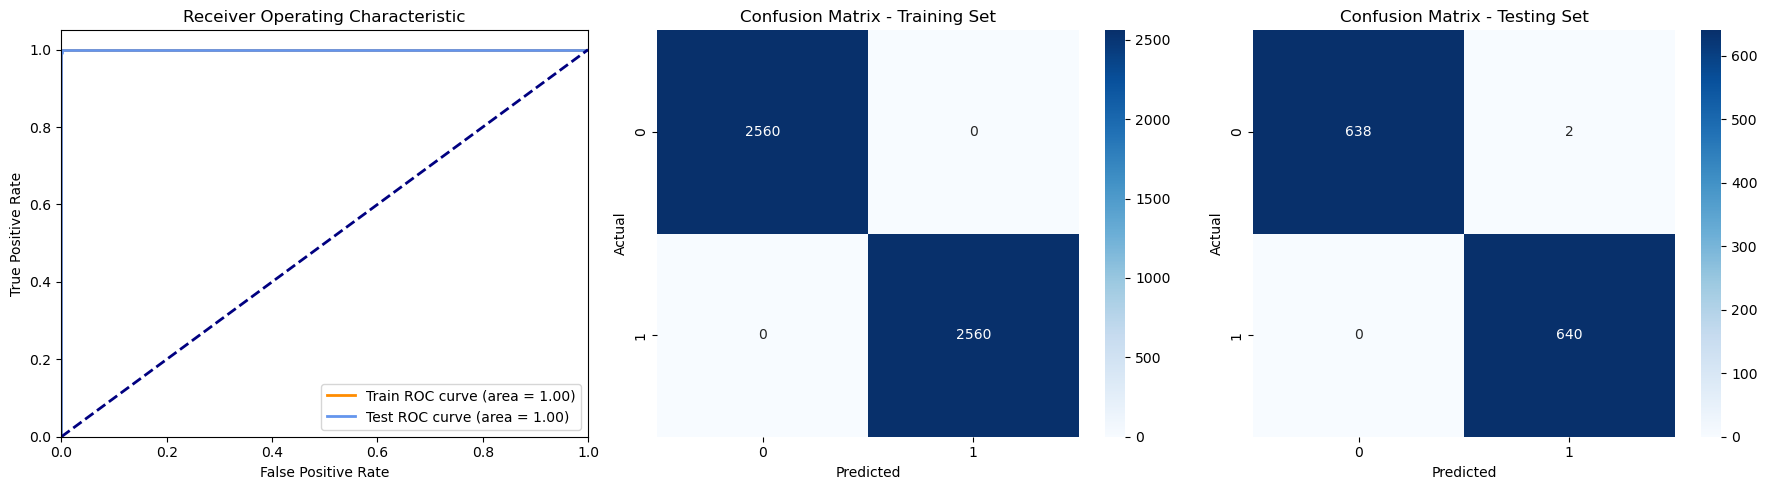

In [74]:
# Define a range of degrees for polynomial features
degrees = [1, 2, 3, 4]

# Top 3 models with best parameters
models = [
    ('Random Forest', RandomForestClassifier(**best_params_rf, random_state=random_seed)),
    ('Decision Tree', DecisionTreeClassifier(**best_params_dt, random_state=random_seed)),
    ('AdaBoost', AdaBoostClassifier(**best_params_ada, random_state=random_seed))
]

# Loop through the models
for model_name, model in models:
    print(f"Evaluating {model_name} with Polynomial Features:")

    # Loop through the degrees and evaluate the model
    for degree in degrees:
        # Create polynomial features
        polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)

        # Create a pipeline with polynomial features and the model
        pipeline = Pipeline([
            ('polynomial_features', polynomial_features),
            (model_name.lower().replace(" ", "_"), model)
        ])

        # Fit the model to the training data
        pipeline.fit(X_train_eng, y_train)

        # Evaluate the model
        print(f"Polynomial Degree: {degree}")
        evaluate_model(pipeline, X_train_eng, y_train, X_test_eng, y_test, f'{model_name} with Polynomial Features (Degree {degree})')
        print("\n" + "="*50 + "\n")  # Separator for better readability

# Stacking Classifier for best performing models

In [75]:
from sklearn.ensemble import StackingClassifier

In [76]:
# Define the base learners
base_learners = [
    ('random_forest', RandomForestClassifier(**best_params_rf, random_state=random_seed)),
    ('decision_tree', DecisionTreeClassifier(**best_params_dt, random_state=random_seed)),
    ('ada_boost', AdaBoostClassifier(**best_params_ada, random_state=random_seed)),
    ('mlp', MLPClassifier(**best_params_mlp, random_state=random_seed)),
    ('gradient_boosting', GradientBoostingClassifier(**best_params_gbm, random_state=random_seed))
]

# Initialize the Stacking Classifier
stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(), n_jobs=-1)

# Fit the stacked model to the training data
stacking_classifier.fit(X_train_eng, y_train)

StackingClassifier(estimators=[('random_forest',
                                RandomForestClassifier(n_estimators=50,
                                                       random_state=1)),
                               ('decision_tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=1)),
                               ('ada_boost',
                                AdaBoostClassifier(learning_rate=0.5,
                                                   n_estimators=100,
                                                   random_state=1)),
                               ('mlp', MLPClassifier(random_state=1)),
                               ('gradient_boosting',
                                GradientBoostingClassifier(max_depth=5,
                                                           random_state=1,
                                                           subsample=0.9))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [77]:
# Evaluate the stacked model


Model: Stacked Ensemble Model
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9977
Precision           1.0       0.9953
Recall              1.0       1.0000
F1-Score            1.0       0.9977
Matthews            1.0       0.9953
ROC AUC             1.0       1.0000
Time Taken (ms): 448.742151260376


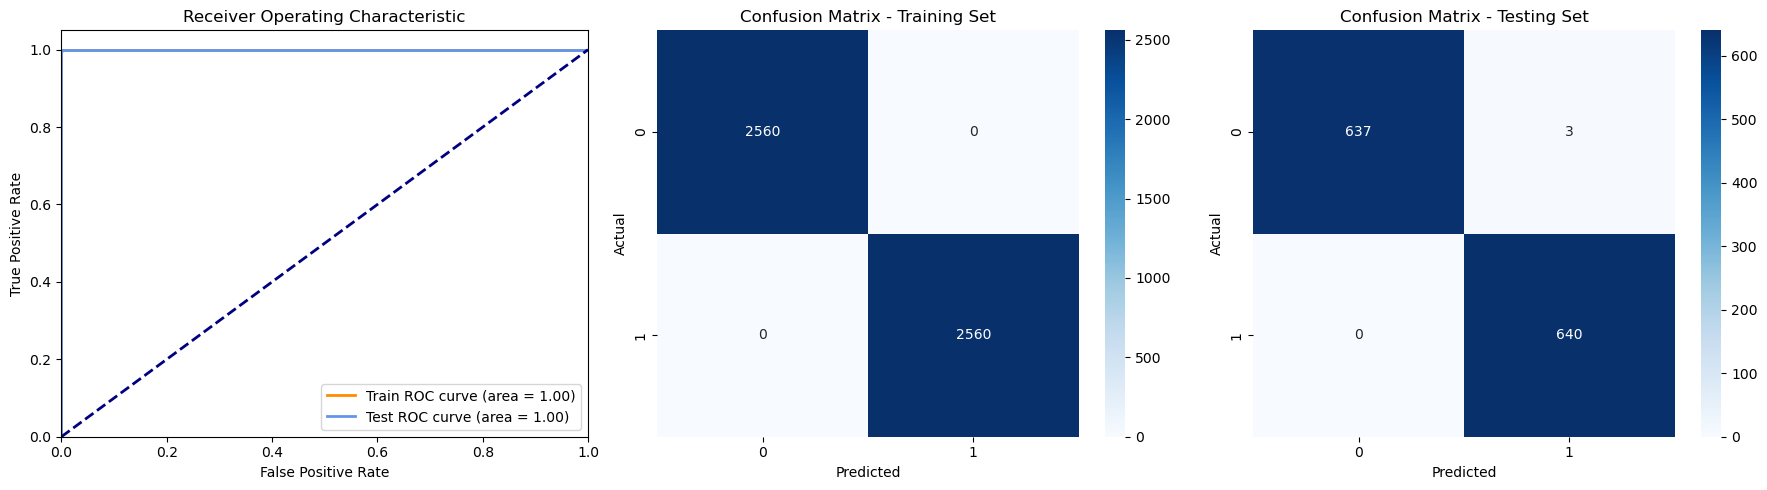

In [78]:
evaluate_model(stacking_classifier, X_train_eng, y_train, X_test_eng, y_test, 'Stacked Ensemble Model')

# Voting Classifier on top performing models

In [79]:
from sklearn.ensemble import VotingClassifier

In [80]:
# Top 5 models with best parameters
models = [
    ('Random Forest', RandomForestClassifier(**best_params_rf, random_state=random_seed)),
    ('Decision Tree', DecisionTreeClassifier(**best_params_dt, random_state=random_seed)),
    ('AdaBoost', AdaBoostClassifier(**best_params_ada, random_state=random_seed)),
    ('Gradient Boosting', GradientBoostingClassifier(**best_params_gbm, random_state=random_seed)),
    ('MLP', MLPClassifier(**best_params_mlp, random_state=random_seed))
]

# Create a Voting Classifier
voting_clf = VotingClassifier(estimators=models, voting='soft')

# Fit the Voting Classifier to the training data
voting_clf.fit(X_train_eng, y_train)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('Decision Tree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     random_state=1)),
                             ('AdaBoost',
                              AdaBoostClassifier(learning_rate=0.5,
                                                 n_estimators=100,
                                                 random_state=1)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         random_state=1,
                                                         subsample=0.9)),
                             ('MLP', MLPClassifier(random_state=1))],
                 voting='soft')

In [81]:
# Evaluate the Voting Classifier


Model: Voting Classifier with Top 5 Models
           Training Set  Testing Set
Metric                              
Accuracy            1.0       0.9977
Precision           1.0       0.9953
Recall              1.0       1.0000
F1-Score            1.0       0.9977
Matthews            1.0       0.9953
ROC AUC             1.0       1.0000
Time Taken (ms): 511.7065906524658


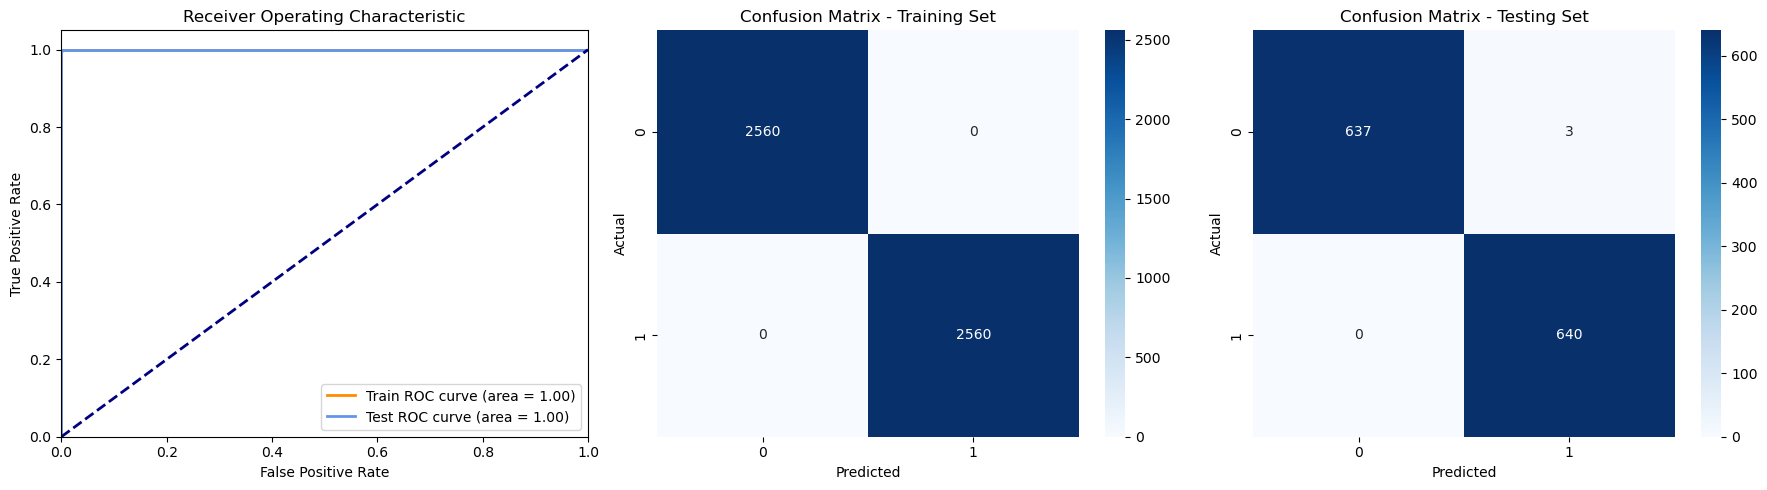

In [82]:
evaluate_model(voting_clf, X_train_eng, y_train, X_test_eng, y_test, 'Voting Classifier with Top 5 Models')

# Using Entirely New Data Collected to see how models react to changes

In [83]:
# Let us import the new data

In [84]:
df_new  = pd.read_csv('data_new_true.csv')
df_new.head()

,Timestamp,Seq Num,Temperature (°C),Humidity (%),Light (lx),UV Index,Pressure (hPa),Noise (dB),Discomfort Index,Heatstroke (°C),Battery Voltage (mV),location
0,8/10/2023 15:22,22,33.37,49.21,17631,2.80,1006.5,43.63,82.54,28.40,2773,outdoor
1,8/11/2023 4:39,64,19.94,71.75,0,0.02,1004.2,38.39,66.35,19.73,2647,outdoor
2,8/10/2023 22:32,199,26.25,61.23,0,0.02,1005.6,38.39,74.71,23.81,2717,indoor
3,8/11/2023 4:05,30,20.27,71.21,0,0.03,1004.6,38.39,66.82,19.97,2654,outdoor
4,8/11/2023 7:10,216,25.12,70.58,0,0.02,1004.9,41.16,74.10,23.98,2692,indoor


In [85]:
df_new = df_new.drop(['Timestamp', 'Seq Num', 'Battery Voltage (mV)', 'Light (lx)'], axis=1)

In [86]:
df_new.head()

,Temperature (°C),Humidity (%),UV Index,Pressure (hPa),Noise (dB),Discomfort Index,Heatstroke (°C),location
0,33.37,49.21,2.80,1006.5,43.63,82.54,28.40,outdoor
1,19.94,71.75,0.02,1004.2,38.39,66.35,19.73,outdoor
2,26.25,61.23,0.02,1005.6,38.39,74.71,23.81,indoor
3,20.27,71.21,0.03,1004.6,38.39,66.82,19.97,outdoor
4,25.12,70.58,0.02,1004.9,41.16,74.10,23.98,indoor


In [87]:
# let us seperate the features from the label

In [88]:
X_new = df_new.drop('location', axis=1)

In [89]:
# Import neccessary libraries

In [90]:
from sklearn.preprocessing import LabelEncoder
from joblib import load

In [91]:
# Encode the new label

In [92]:
# Define the target variable
y_new_true = df_new['location']

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_new_encoded = label_encoder.fit_transform(y_new_true)

# The encoded values are now in y_encoded
print(y_new_encoded)

[1 1 0 ... 0 1 1]


In [93]:
# Loading the saved scaler

In [94]:
scaler_loaded = load('scaler.joblib')

In [95]:
X_new_scaled = scaler_loaded.transform(X_new)

In [96]:
# Let us do engineering of the new dataset

In [97]:
# Calculate the average of the relevant features in the test set
X_new_scaled_df = pd.DataFrame(X_new_scaled, columns=X_new.columns)
X_new_engineered = X_new_scaled_df.copy()
X_new_engineered['composite_heat_index'] = X_new_scaled_df[['Temperature (°C)', 'Discomfort Index', 'Heatstroke (°C)']].mean(axis=1)

# Drop the original features
X_new_engineered = X_new_engineered.drop(columns=['Temperature (°C)', 'Discomfort Index', 'Heatstroke (°C)'])

# Show the engineered features
X_new_engineered.head()

,Humidity (%),UV Index,Pressure (hPa),Noise (dB),composite_heat_index
0,-0.695983,46.333333,0.489051,0.985656,1.735640
1,0.735355,0.000000,0.321168,-0.088115,-0.236082
2,0.067312,0.000000,0.423358,-0.088115,0.718223
3,0.701064,0.166667,0.350365,-0.088115,-0.182672
4,0.661057,0.000000,0.372263,0.479508,0.657710


# Making predictions on the new data using top perfoming models

In [98]:
# Assuming these models are already trained with the best parameters
y_new_pred_rf = best_rf_model.predict(X_new_engineered)  # Random Forest predictions
y_new_pred_gbm = best_gbm_model.predict(X_new_engineered)  # Gradient Boosting predictions
y_new_pred_dt = best_dt_model.predict(X_new_engineered)  # Decision Tree predictions
y_new_pred_ada = best_ada_model.predict(X_new_engineered)  # AdaBoost predictions
y_new_pred_mlp = best_mlp_model.predict(X_new_engineered)  # MLP predictions

In [99]:
from sklearn.metrics import classification_report

print("Classification Report for Random Forest on New Data (Collected a month later):")
print(classification_report(y_new_encoded, y_new_pred_rf))

print("\nClassification Report for Gradient Boosting on New Data (Collected a month later):")
print(classification_report(y_new_encoded, y_new_pred_gbm))

print("\nClassification Report for Decision Tree on New Data (Collected a month later):")
print(classification_report(y_new_encoded, y_new_pred_dt))

print("\nClassification Report for AdaBoost on New Data (Collected a month later):")
print(classification_report(y_new_encoded, y_new_pred_ada))

print("\nClassification Report for MLP on New Data (Collected a month later):")
print(classification_report(y_new_encoded, y_new_pred_mlp))

Classification Report for Random Forest on New Data (Collected a month later):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       561
           1       1.00      0.80      0.89       557

    accuracy                           0.90      1118
   macro avg       0.92      0.90      0.90      1118
weighted avg       0.92      0.90      0.90      1118


Classification Report for Gradient Boosting on New Data (Collected a month later):
              precision    recall  f1-score   support

           0       0.76      0.97      0.86       561
           1       0.96      0.70      0.81       557

    accuracy                           0.84      1118
   macro avg       0.86      0.83      0.83      1118
weighted avg       0.86      0.84      0.83      1118


Classification Report for Decision Tree on New Data (Collected a month later):
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     

# Voting Classifier on new data

In [100]:
# Making Prediction on the voting classifier

In [101]:
y_new_pred_voting = voting_clf.predict(X_new_engineered)

In [102]:
# Getting metrics of the voting classifier

In [103]:
print("Classification Report for Voting Classifier on New Data (Collected a month later):")
print(classification_report(y_new_encoded, y_new_pred_voting))

Classification Report for Voting Classifier on New Data (Collected a month later):
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       561
           1       0.97      0.70      0.81       557

    accuracy                           0.84      1118
   macro avg       0.87      0.84      0.84      1118
weighted avg       0.87      0.84      0.84      1118



# Stacking Classifier on new data

In [104]:
# Use the stacking classifier to make predictions on the new data

In [105]:
y_new_pred_stacking = stacking_classifier.predict(X_new_engineered)

In [106]:
# Getting metrics for the stacking classifier

In [107]:
print("Classification Report for Stacking Classifier on New Data (Collected a month later):")
print(classification_report(y_new_encoded, y_new_pred_stacking))

Classification Report for Stacking Classifier on New Data (Collected a month later):
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       561
           1       0.97      0.70      0.81       557

    accuracy                           0.84      1118
   macro avg       0.87      0.84      0.84      1118
weighted avg       0.87      0.84      0.84      1118

